## Setup

In [80]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from src.regex_pattern_generator import generate_regex_patterns


# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [81]:
INAUGURATION_DATE = datetime(2025, 1, 20)
CONTEXT_WINDOW = 200 # words to display for context

In [82]:
# PHRASES = ['Deal', # 25+ times
# 'Thousand / Million / Billion', # 12+ times',
# 'Israel / Gaza', # 7+ times',
# 'Border', # 5+ times
# 'China', # 5+ times
# 'Biden', # 3+ times
# 'NATO',
# 'Ceasefire',
# 'King',
# 'Chip / Ship',
# 'Hell',
# 'Gaza Strip',
# "Women's sports",
# 'Hottest',
# 'Shield',
# 'AI / Artificial Intelligence',
# 'Bitcoin / Crypto']
PHRASES = ['Pharmaceutical',
 'Zelenskyy / Zelensky / Zelenskiy',
 'Trade Deal',
 'Tariff',
 'Scotch / Whisky',
 'Sanction',
 'Russia / Ukraine',
 'Queen',
 'Putin',
 'Nuclear',
 'NATO',
 'London',
 'King',
 'Immigration / Migration',
 'Hamas',
 'Golf',
 'Gaza / Israel',
 'Europe / European',
 'Energy',
 'Churchill',
 'Charlie',
 'Carriage',
 'Buckingham / Windsor',
 'Biden',
 'Agriculture / Agricultural'
 ,'Nuclear energy']

SEARCH_PHRASES = generate_regex_patterns(PHRASES)

from pprint import pprint
pprint(SEARCH_PHRASES)

{'Agriculture / Agricultural': "\\b(?:\\w+-)*(?:(?:agriculture|agricultures|agriculture's|agricultures'|agricultural|agriculturals|agricultural's|agriculturals'))(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Biden': "\\b(?:\\w+-)*(?:biden|bidens|biden's|bidens')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Buckingham / Windsor': "\\b(?:\\w+-)*(?:(?:buckingham|buckinghams|buckingham's|buckinghams'|windsor|windsors|windsor's|windsors'))(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Carriage': "\\b(?:\\w+-)*(?:carriage|carriages|carriage's|carriages')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Charlie': "\\b(?:\\w+-)*(?:charlie|charlies|charlie's|charlies')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Churchill': "\\b(?:\\w+-)*(?:churchill|churchills|churchill's|churchills')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Energy': "\\b(?:\\w+-)*(?:energy|energies|energy's|energys'|energies')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Europe / European': "\\b(?:\\w+-)*(?:(?:europe|europes|europe's|europes'|european|europeans|european's|europeans'))(?:-\\w+)*(?=\\W|$)[.,!?;:]*",


In [83]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    """Find phrase in text with surrounding context"""
    matches = []
    for match in re.finditer(pattern, text.lower()):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        # Add ellipsis if we're not at the start/end of the text
        if start > 0:
            context = '...' + context
        if end < len(text):
            context = context + '...'
        matches.append(context)
    return matches

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        for file in files:
            if file.endswith('.txt'):
                filepath = os.path.join(root, file)
                try:
                    date = get_date_from_filename(file)
                    text = read_transcript(filepath)
                    counts = count_phrases(text)
                    
                    results.append({
                        'date': date,
                        'file': file,
                        'category': category,
                        'text_length': len(text.split()),
                        'text': text,  # Store full text for context analysis
                        **counts
                    })
                except Exception as e:
                    print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    print("\nOnly 'speech' and 'sotu' categories will be analyzed.\n")
    
    return pd.DataFrame(results)


In [84]:
# Set the category of interest
CATEGORY_OF_INTEREST = "press conference"

# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Filter out press briefings and state of the union
df = df[df['category'] != 'press briefing']
df = df[df['category'] != 'sotu']

# Split data by date and category
speech_mask = df['category'] == 'speech'
category_mask = df['category'] == CATEGORY_OF_INTEREST
date_mask = df['date'] >= INAUGURATION_DATE

# Create category of interest dataframes 
df_category = df[category_mask]
df_category_pre = df[category_mask & ~date_mask]
df_category_post = df[category_mask & date_mask]

df_non_category = df[~category_mask]

# Create SOTU dataframes
sotu_mask = df['category'] == 'sotu'
df_sotu = df[sotu_mask]

df_pre = df[~date_mask]
df_post = df[date_mask]

# Print dataset statistics
print("Dataset Statistics:")

print(f"\n{CATEGORY_OF_INTEREST.title()}s:")
print(f"Pre-inauguration: {len(df_category_pre)}")
print(f"Post-inauguration: {len(df_category_post)}")
print("\nState of the Union:")
print(f"Total: {len(df_sotu)}")

print("\nWord Count Statistics:")

print(f"\n{CATEGORY_OF_INTEREST.title()}s:")
print(f"Pre-inauguration average length: {df_category_pre['text_length'].mean():.0f} words") 
print(f"Post-inauguration average length: {df_category_post['text_length'].mean():.0f} words")
print("\nState of the Union:")
print(f"Average length: {df_sotu['text_length'].mean():.0f} words")

print("\nDate Ranges:")

print(f"\n{CATEGORY_OF_INTEREST.title()}s:")
print(f"Pre-inauguration: {df_category_pre['date'].min().strftime('%Y-%m-%d')} to {df_category_pre['date'].max().strftime('%Y-%m-%d')}")
print(f"Post-inauguration: {df_category_post['date'].min().strftime('%Y-%m-%d')} to {df_category_post['date'].max().strftime('%Y-%m-%d')}")


Categories found in directory:
- donald trump vlog
- interview
- interview - pending
- press briefing
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech
- un-addresses
- uncategorized

Only 'speech' and 'sotu' categories will be analyzed.

Dataset Statistics:

Press Conferences:
Pre-inauguration: 12
Post-inauguration: 13

State of the Union:
Total: 0

Word Count Statistics:

Press Conferences:
Pre-inauguration average length: 7312 words
Post-inauguration average length: 5246 words

State of the Union:
Average length: nan words

Date Ranges:

Press Conferences:
Pre-inauguration: 2024-01-11 to 2025-01-07
Post-inauguration: 2025-01-30 to 2025-08-15


## Phrase Frequency Over Time

Speeches dropped off dramatically between election day and inauguration day. Non-speech transcripts mostly don't go back as far in time (need to scrape more data)


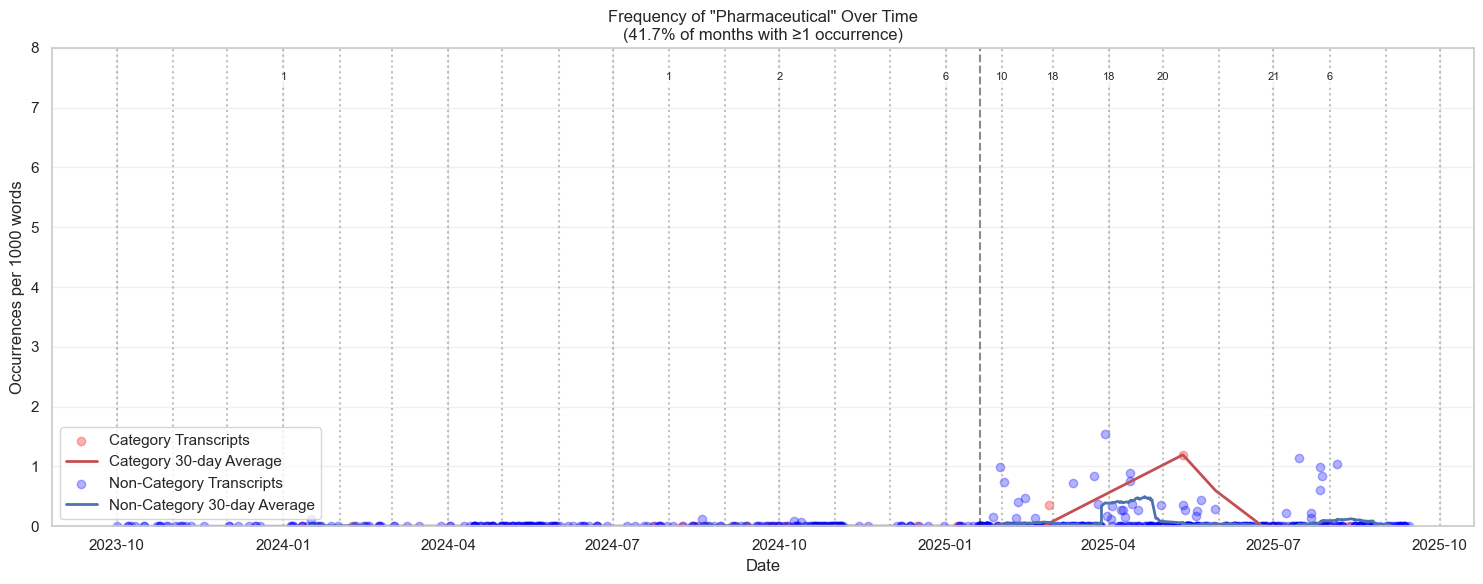


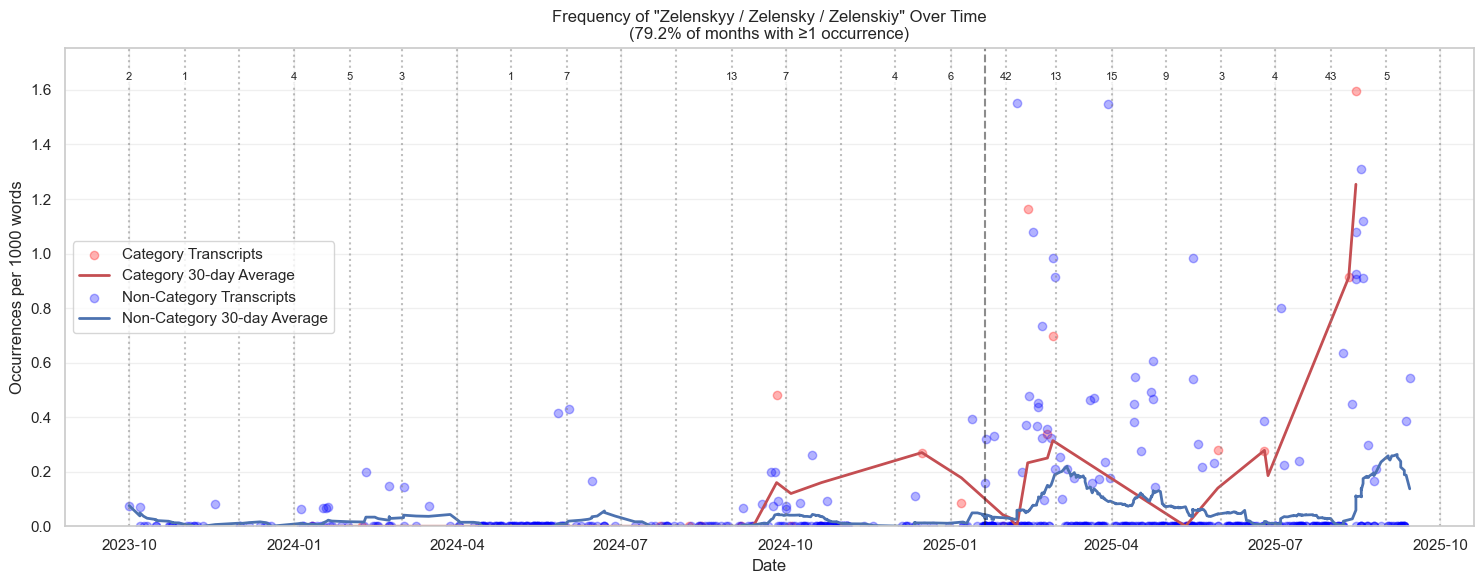


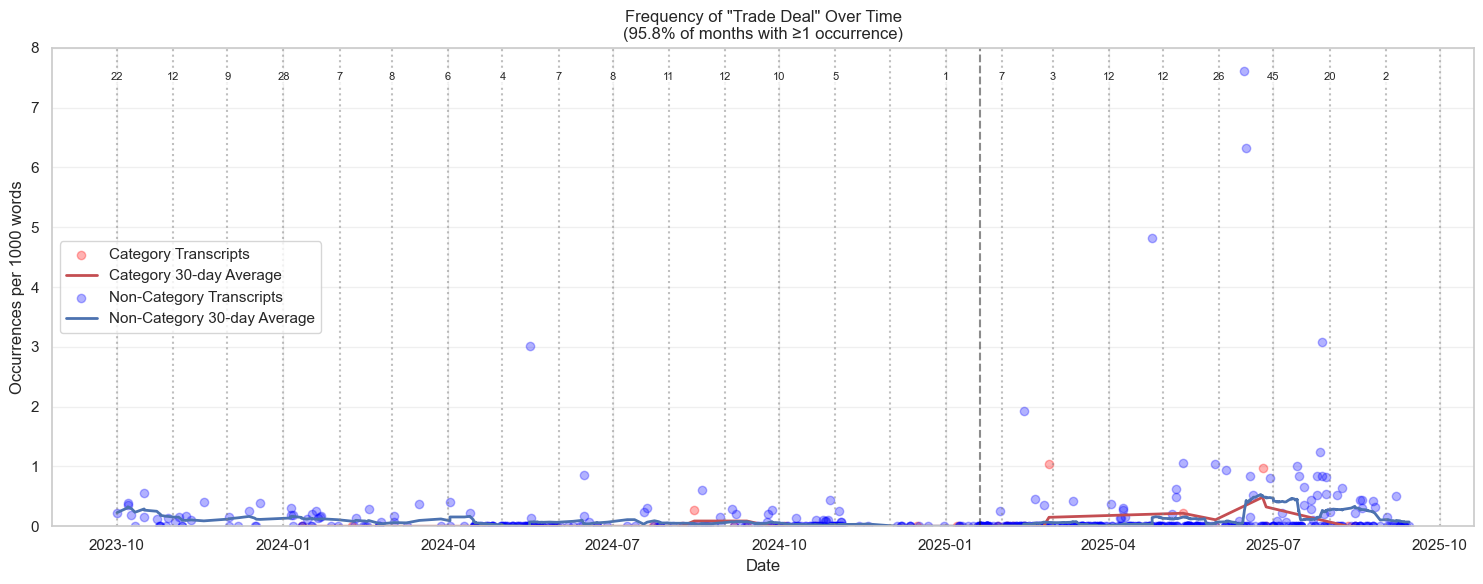


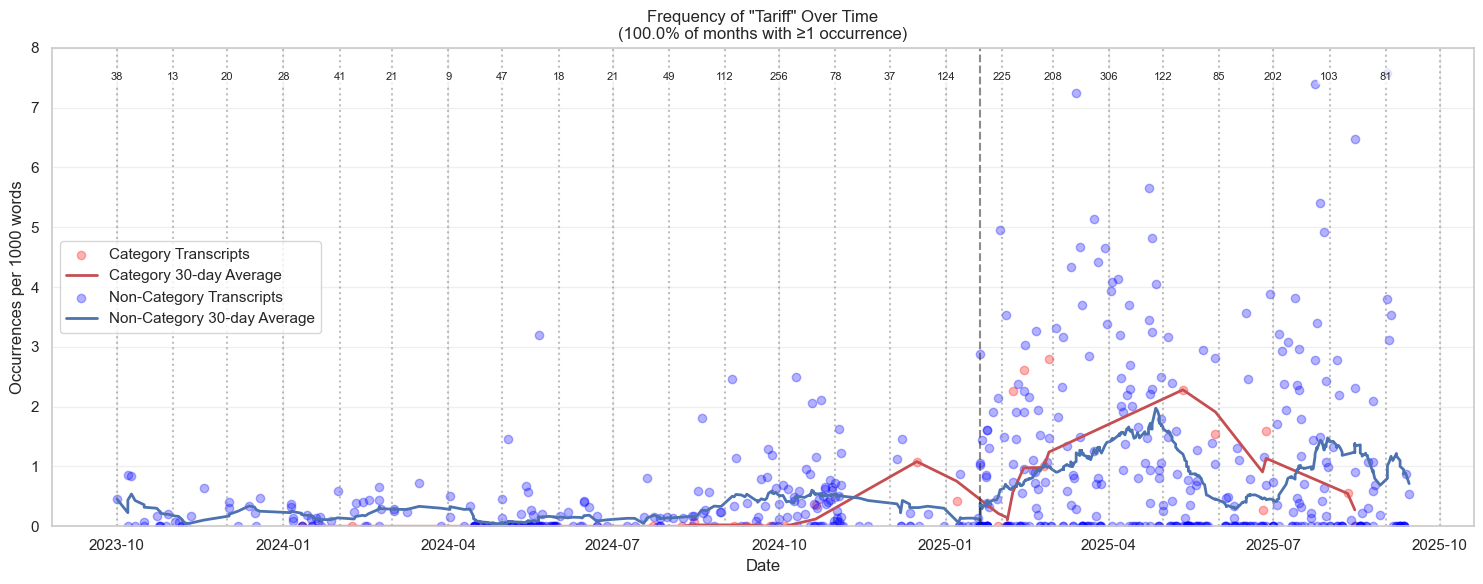

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_85738/3080752663.py:86: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)



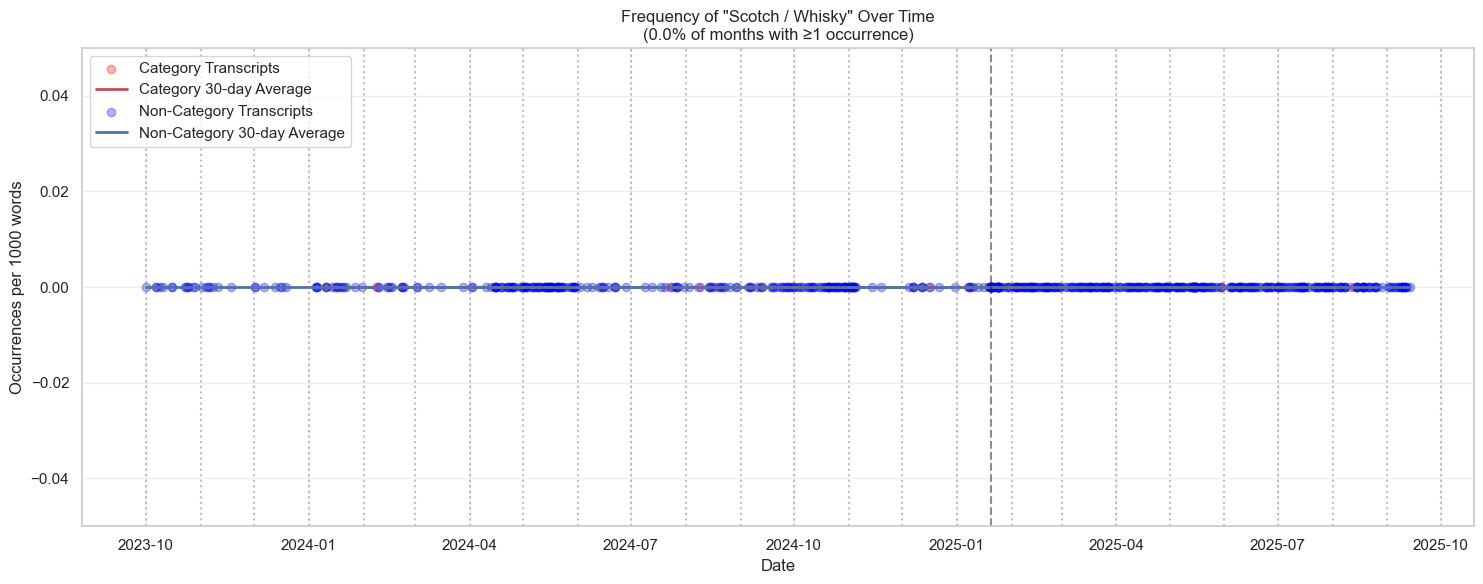


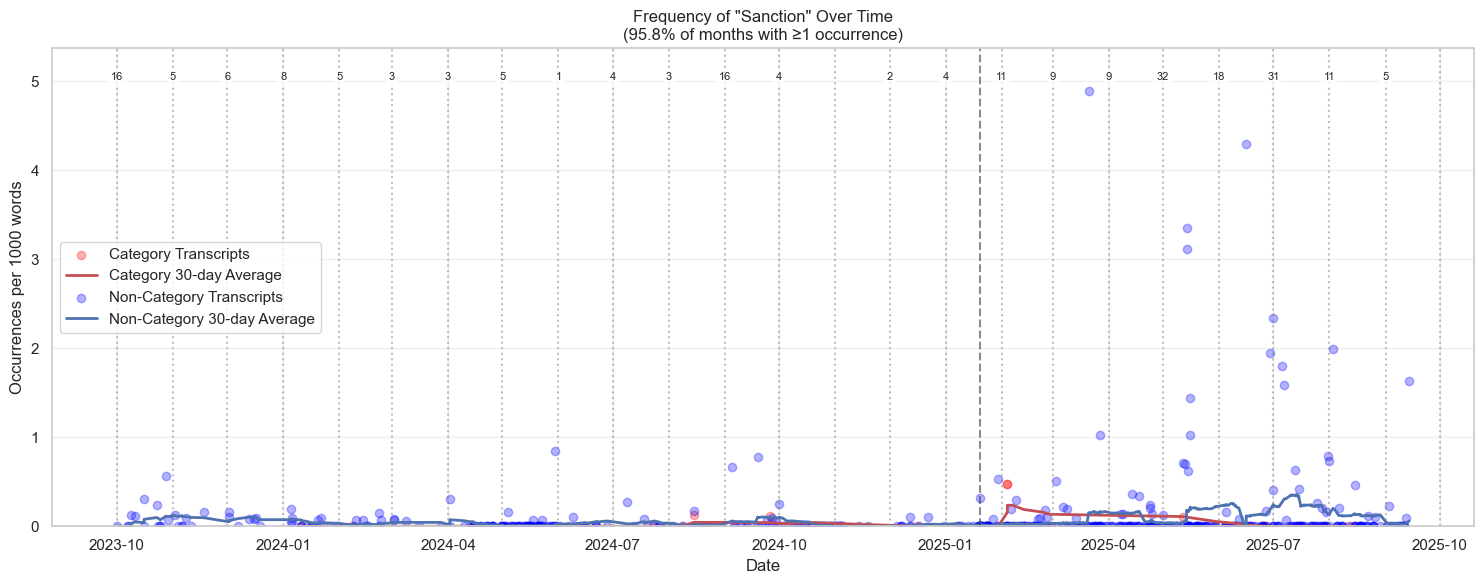


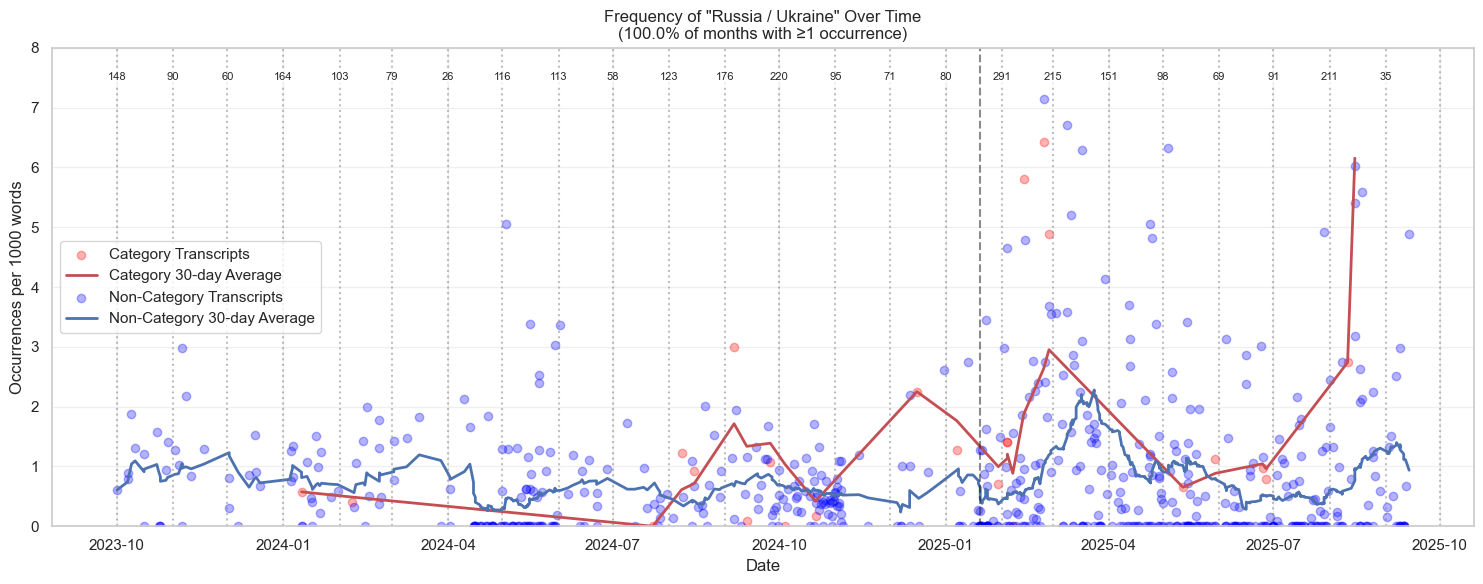


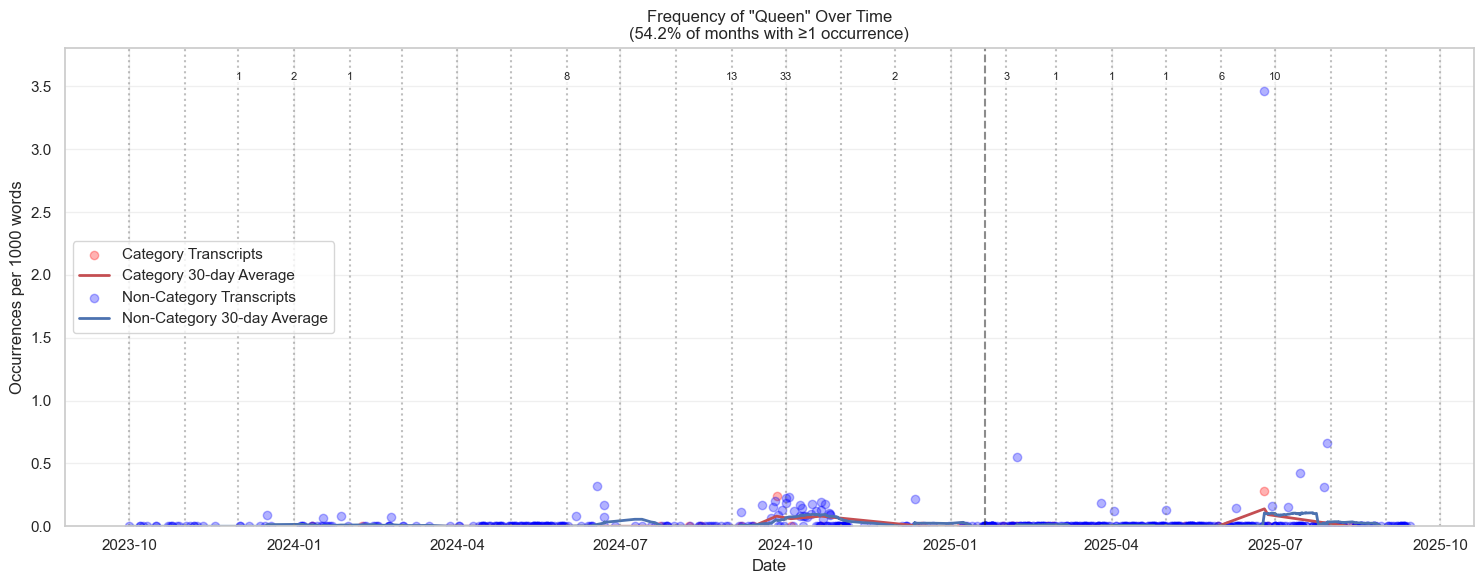


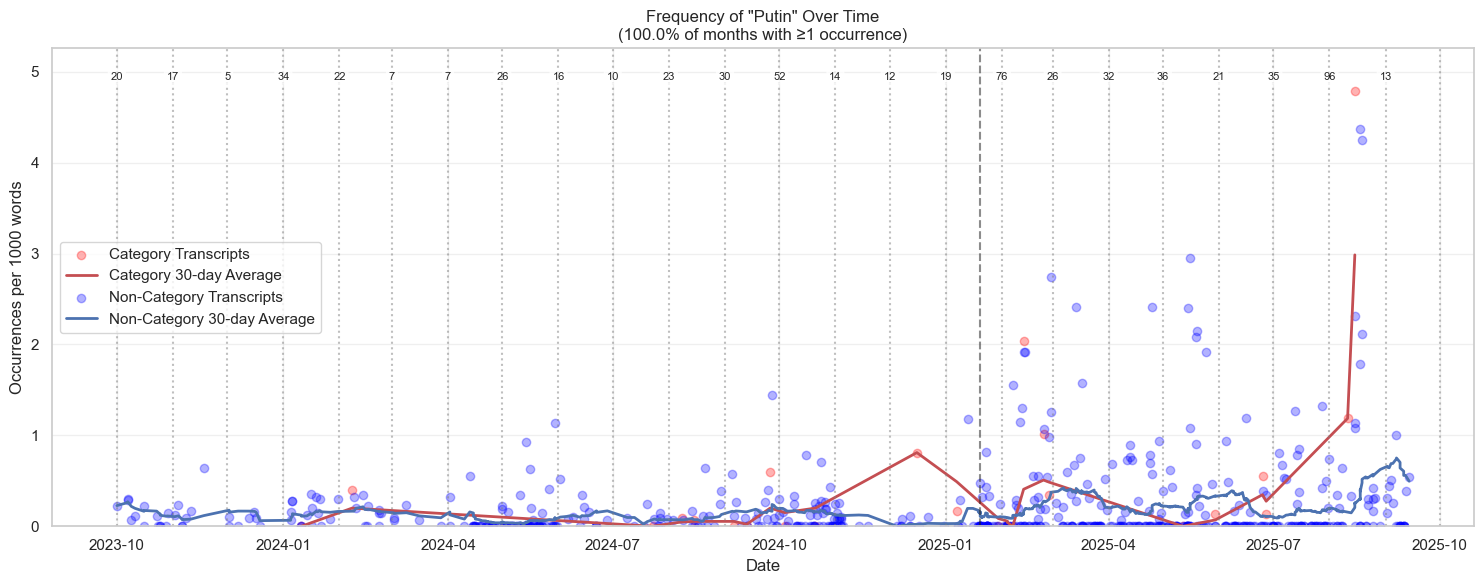


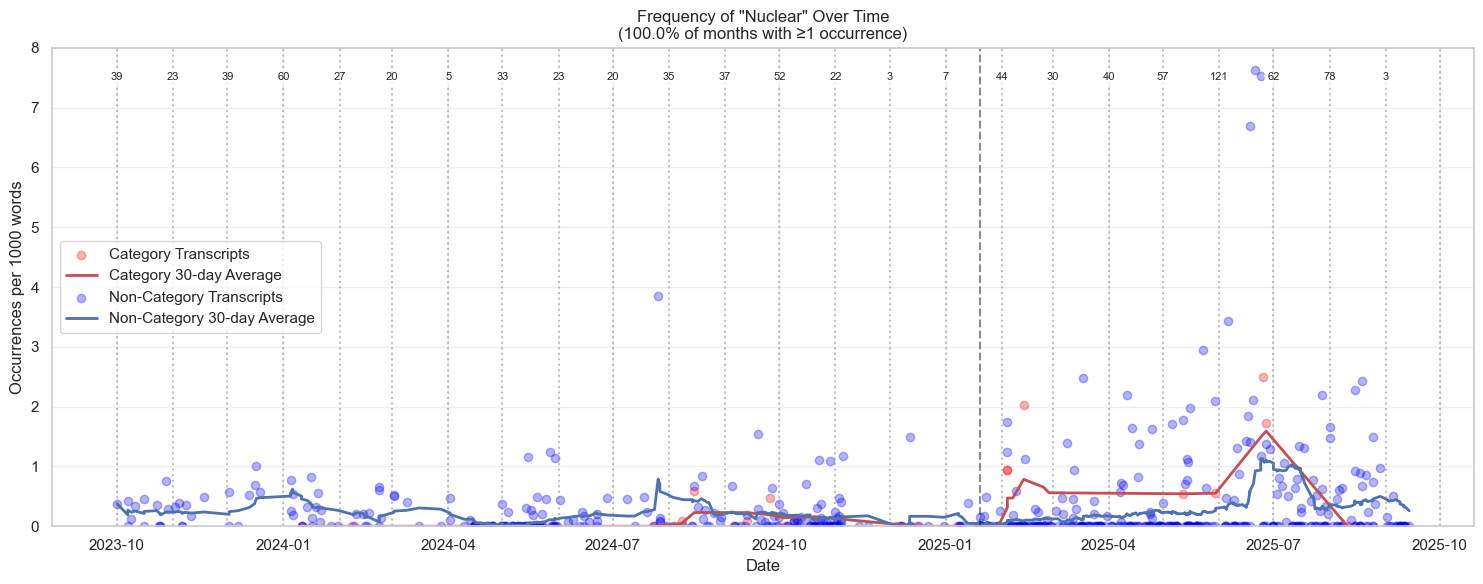


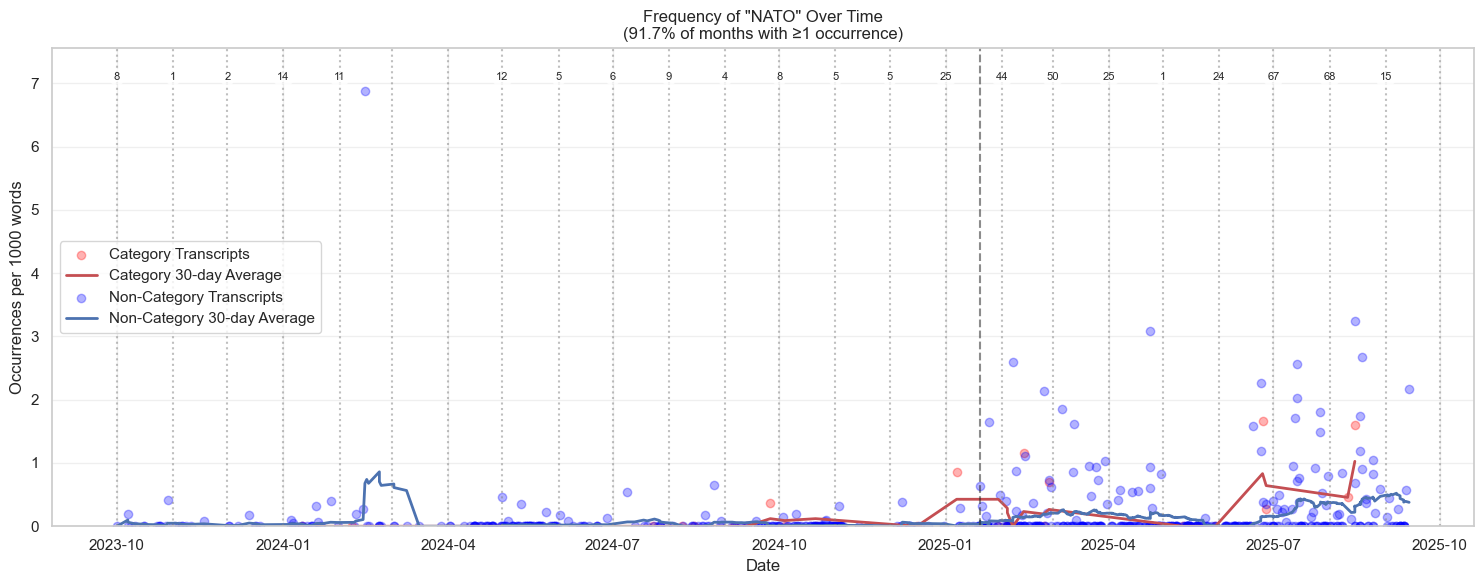


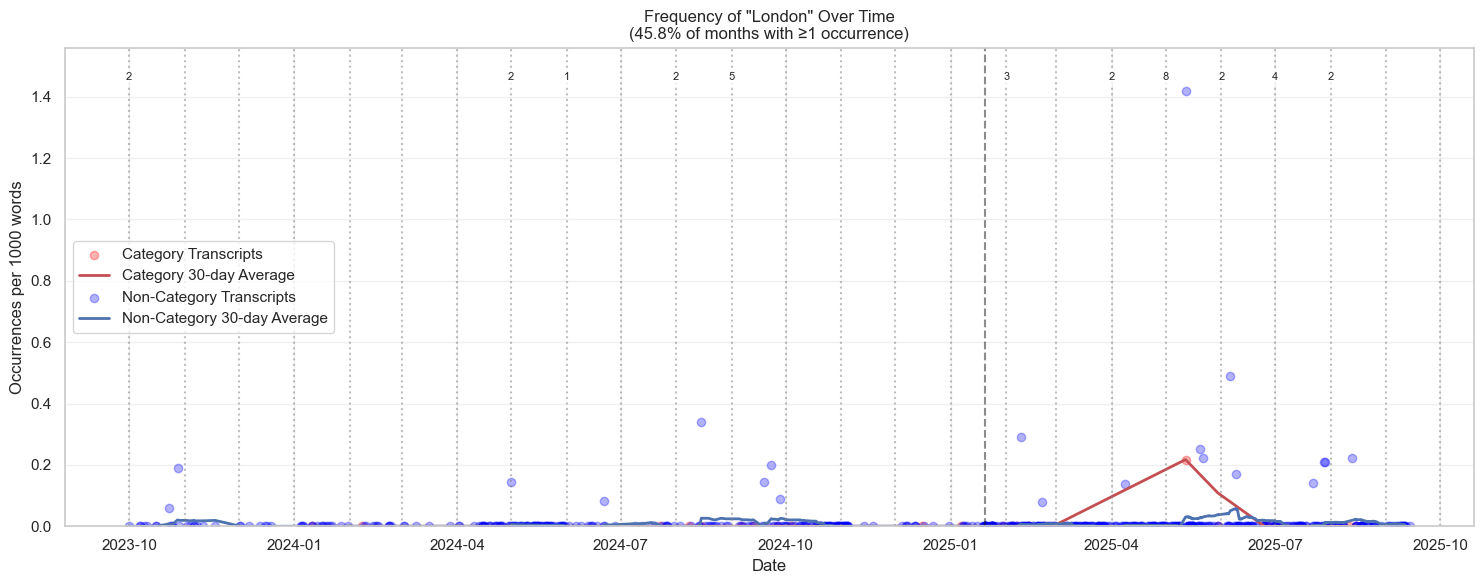


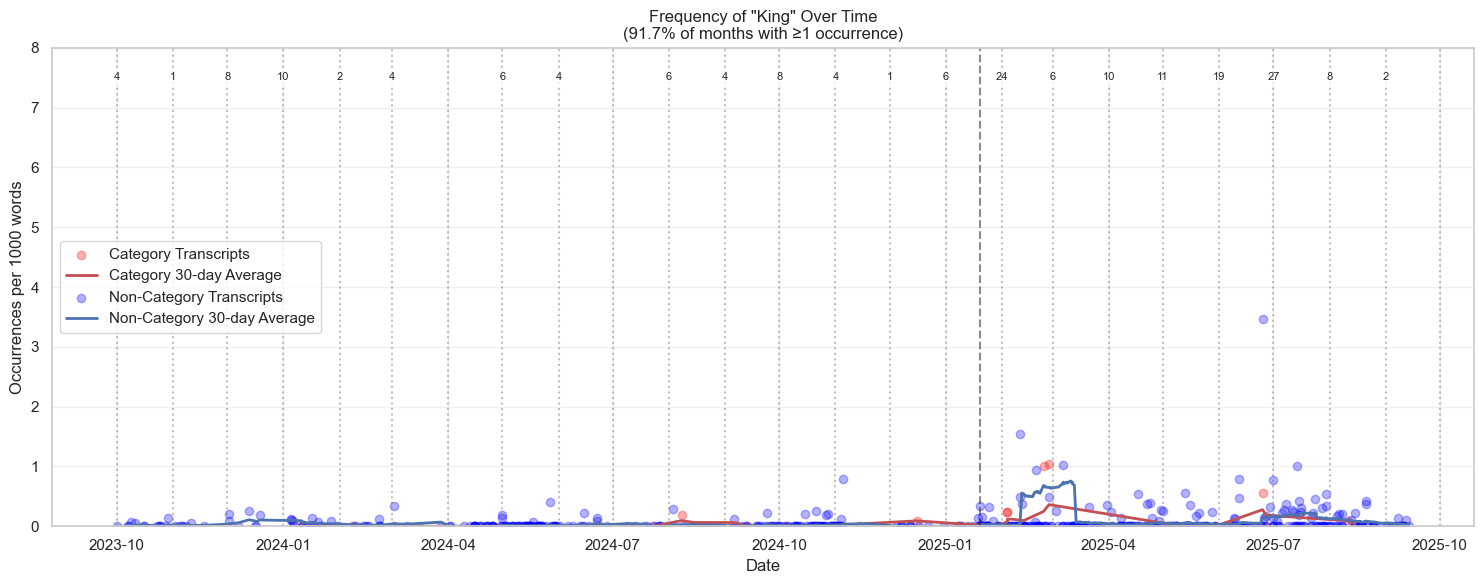


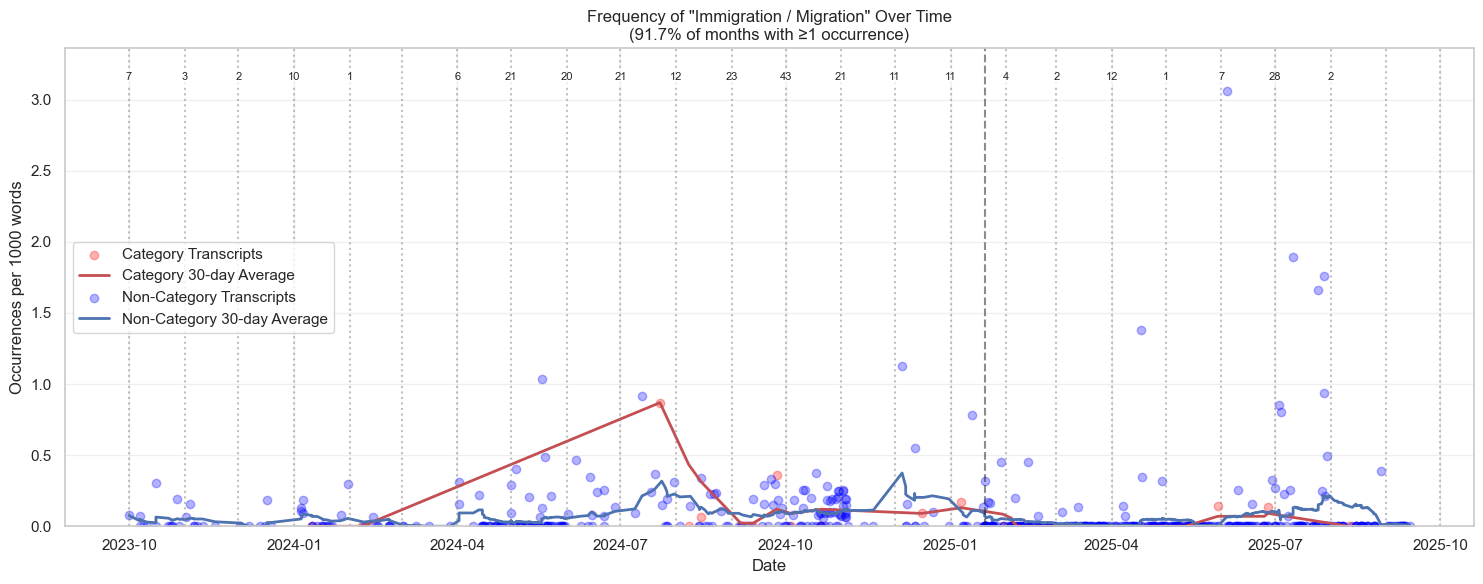


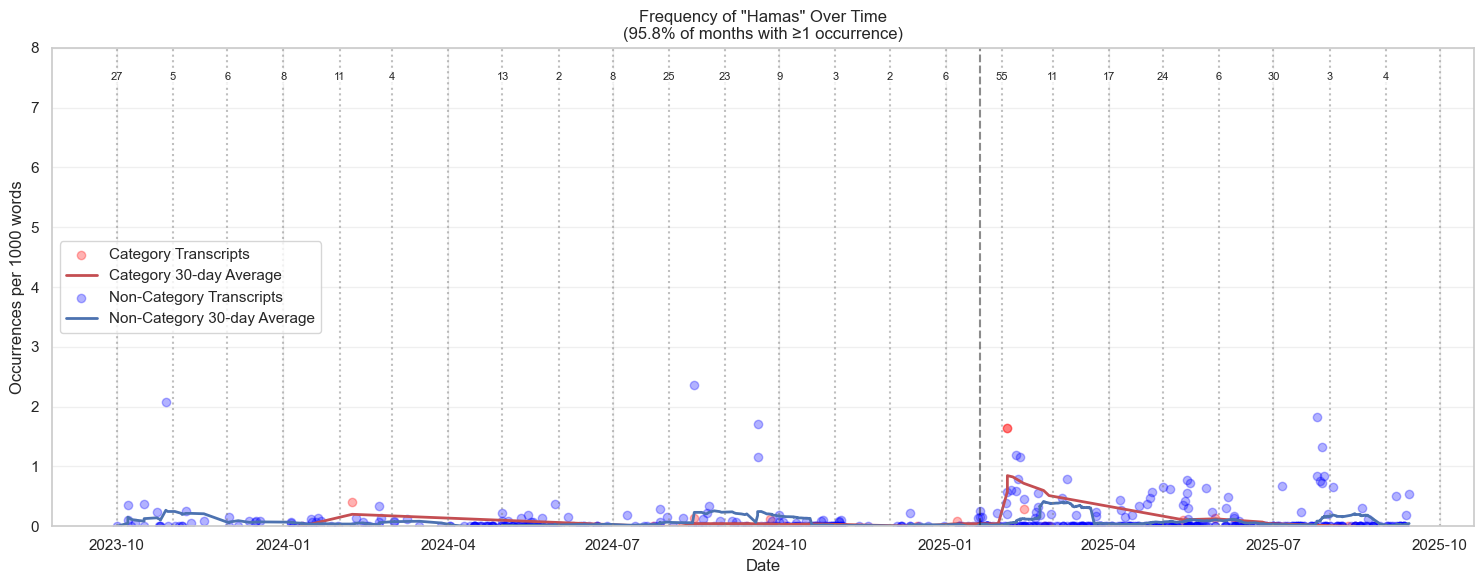


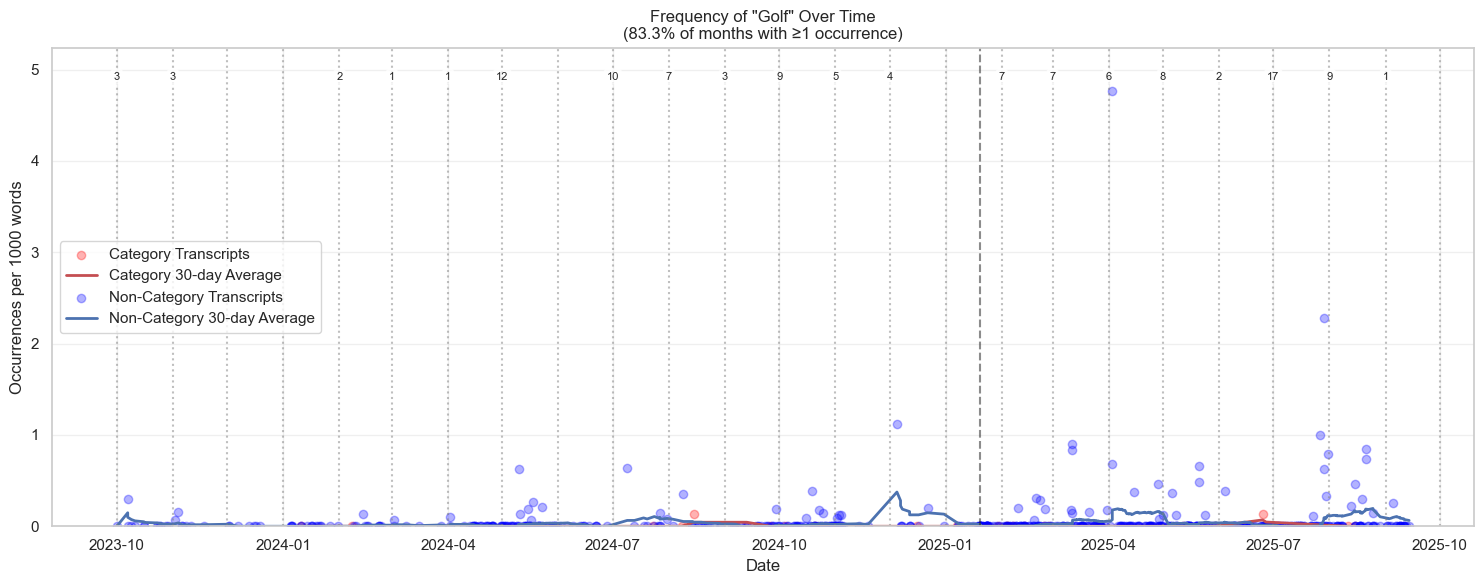


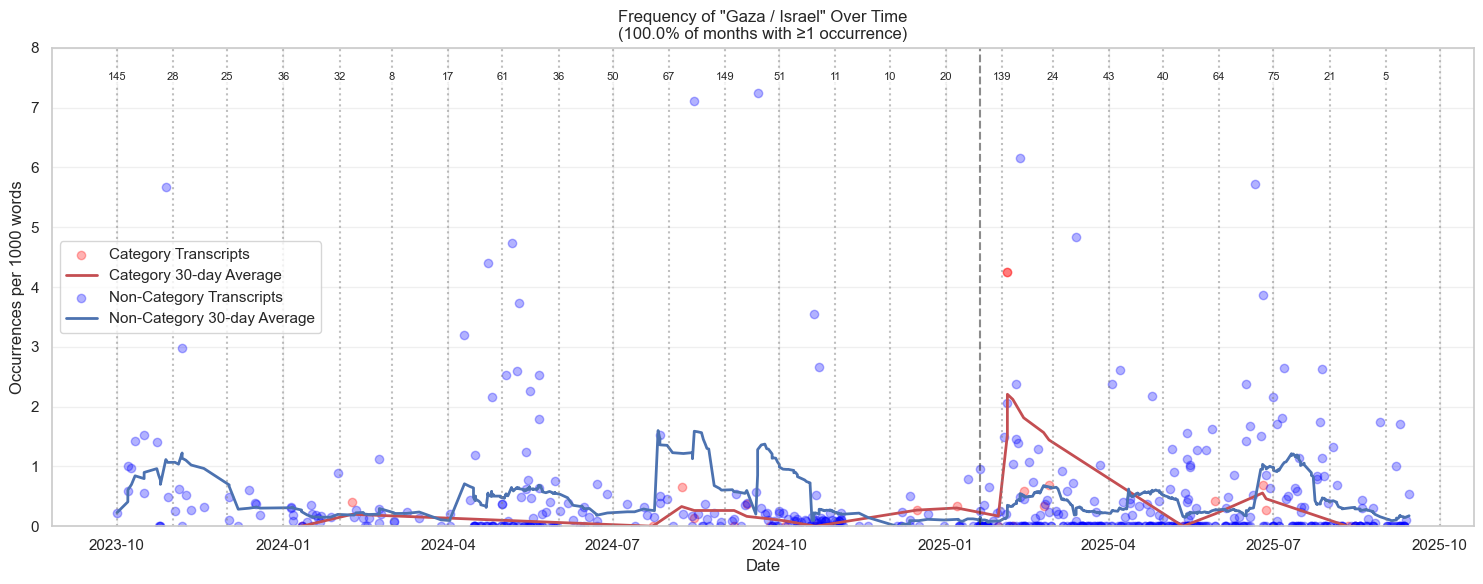


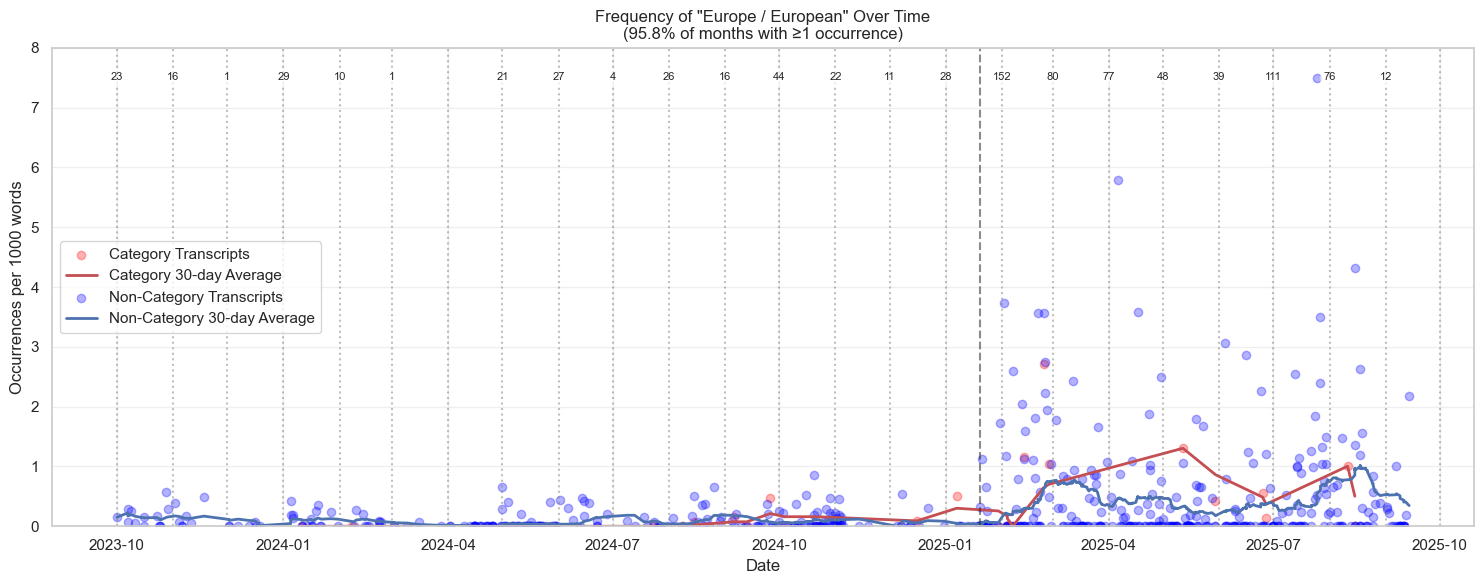


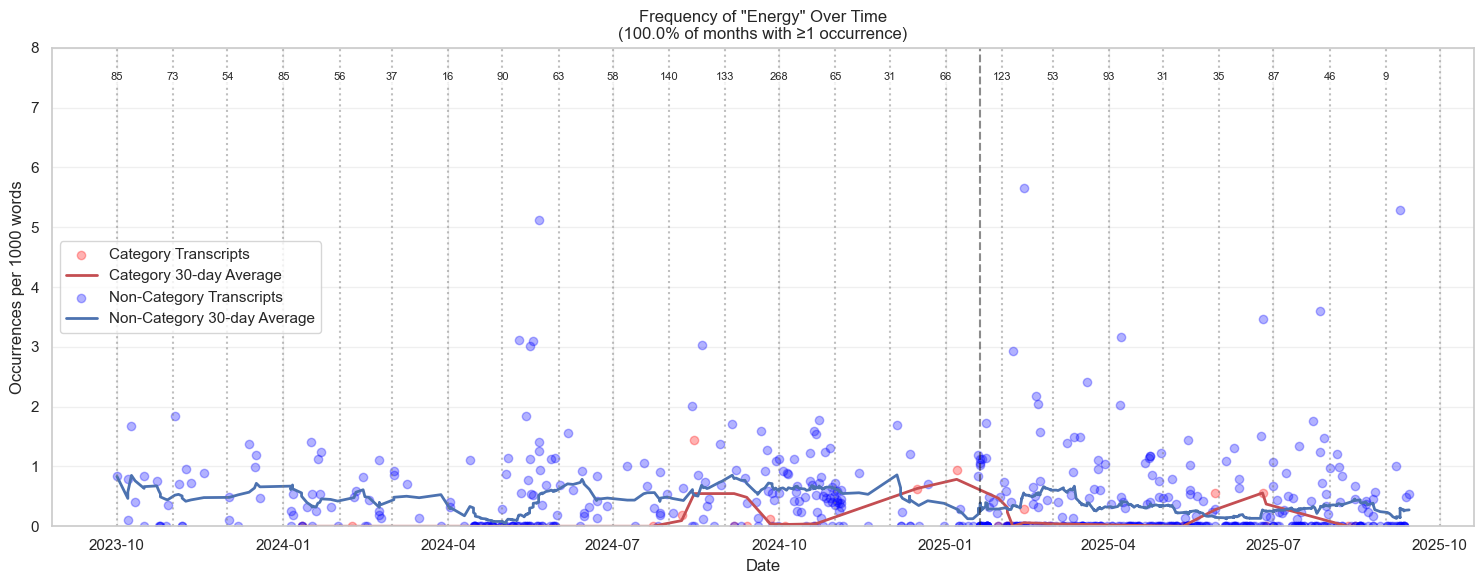


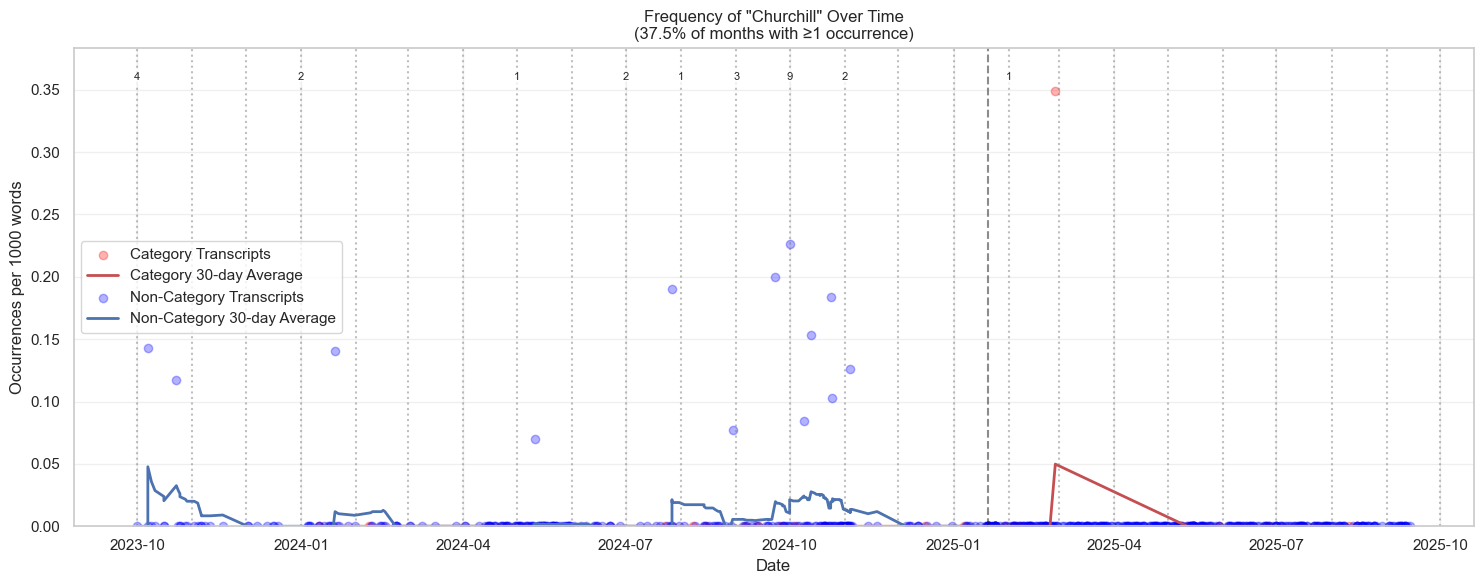


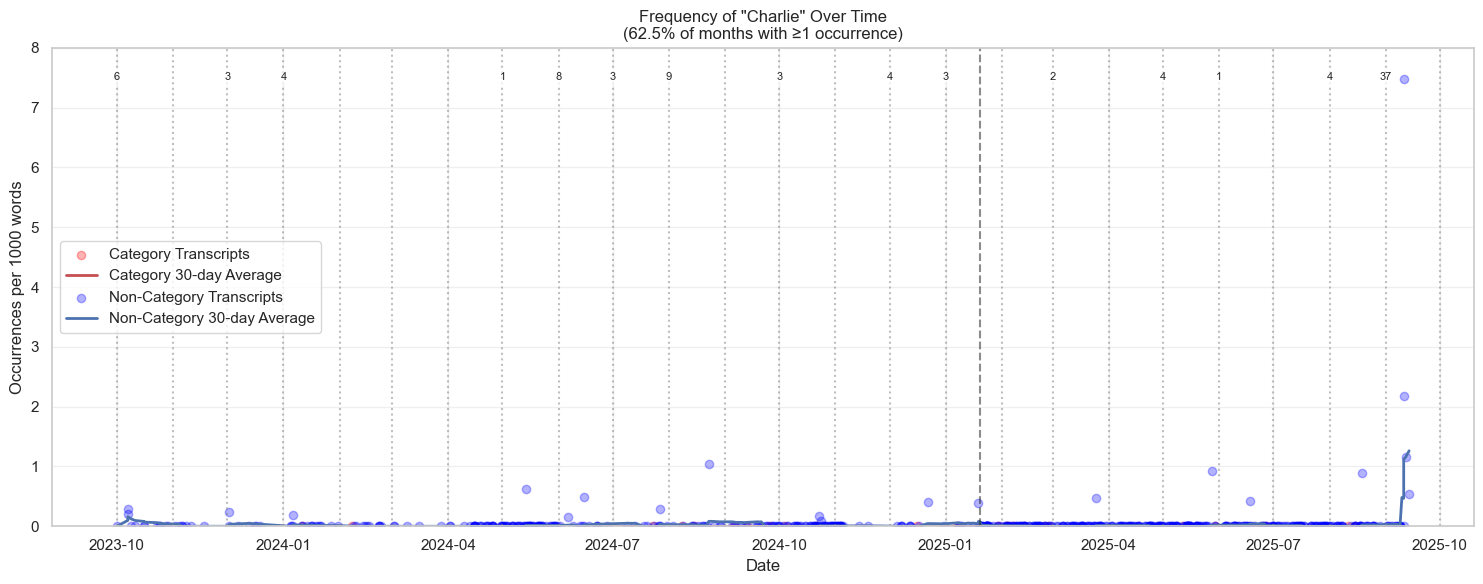

/var/folders/_t/ds12gpdx0qb6km94c759_z9m0000gn/T/ipykernel_85738/3080752663.py:86: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, ymax)



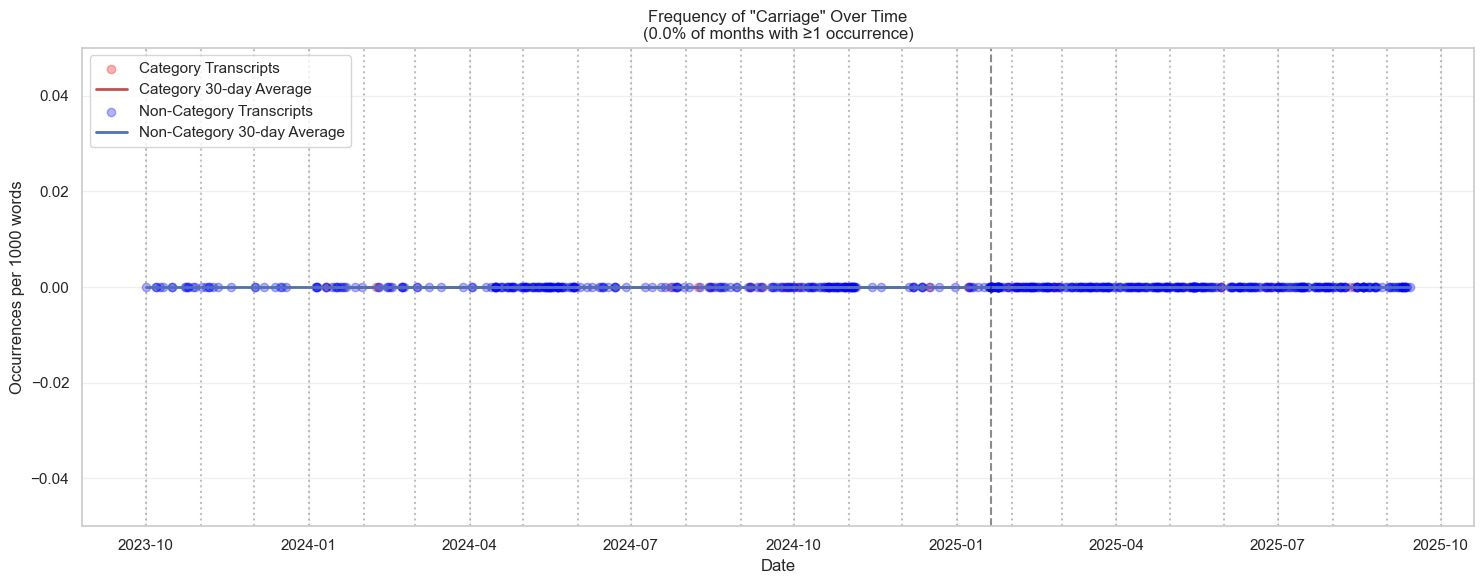


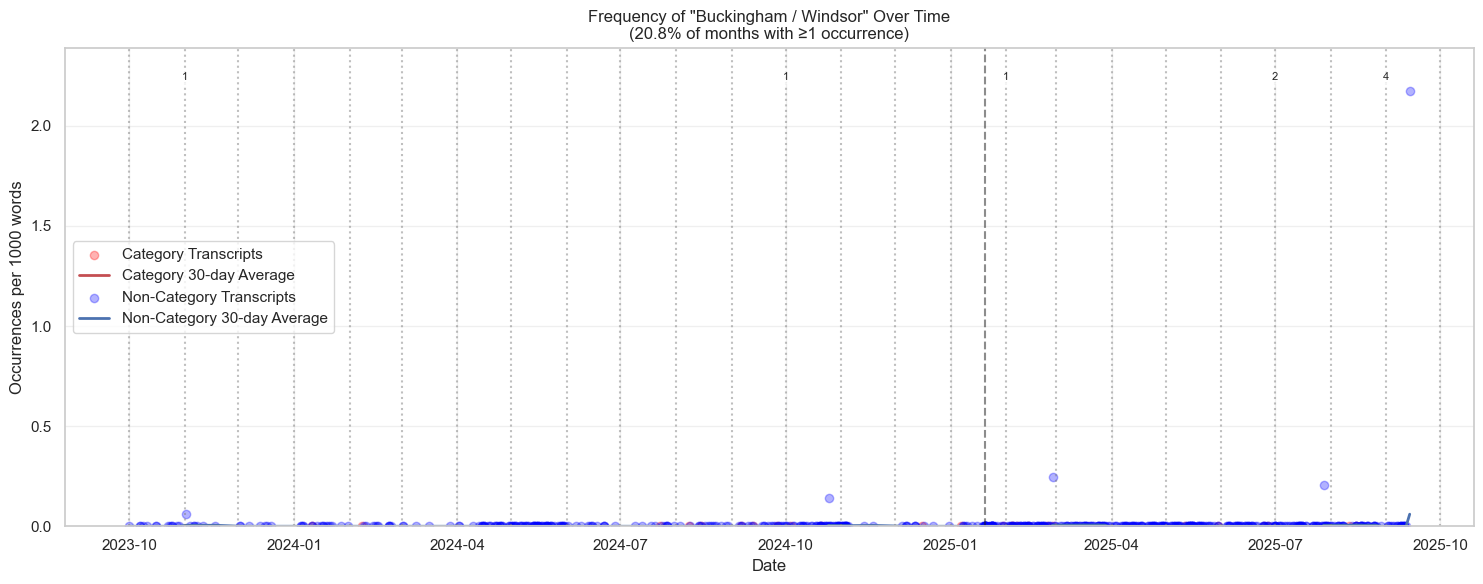


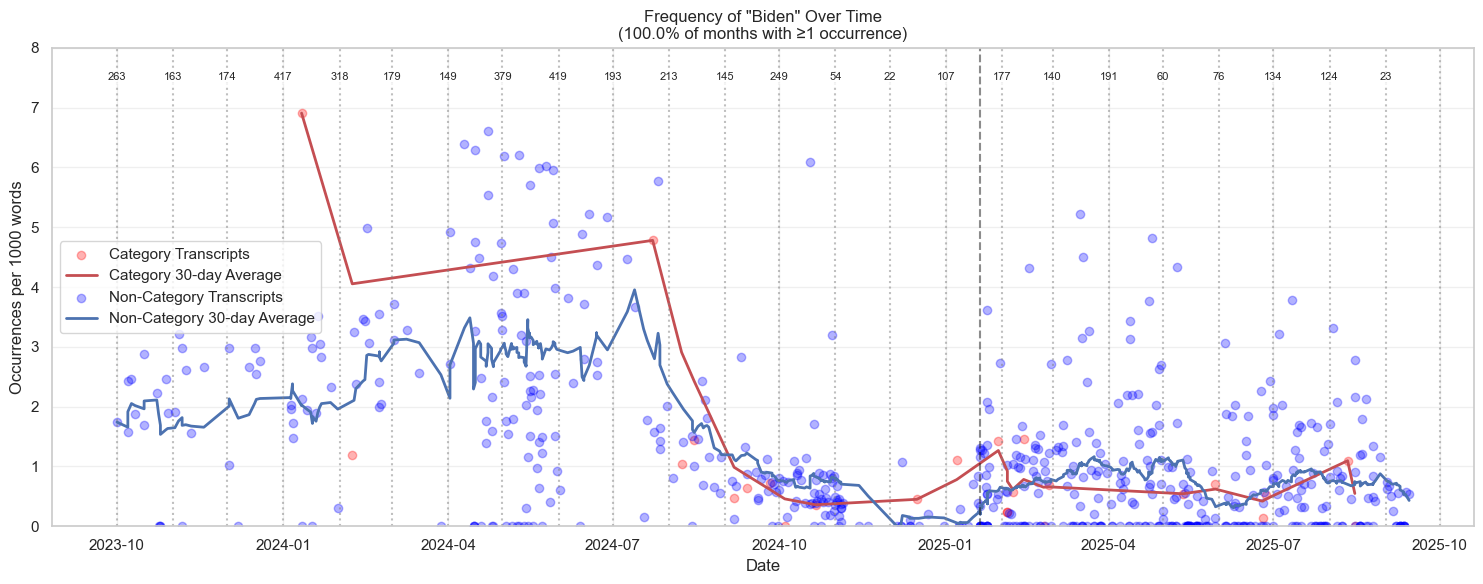


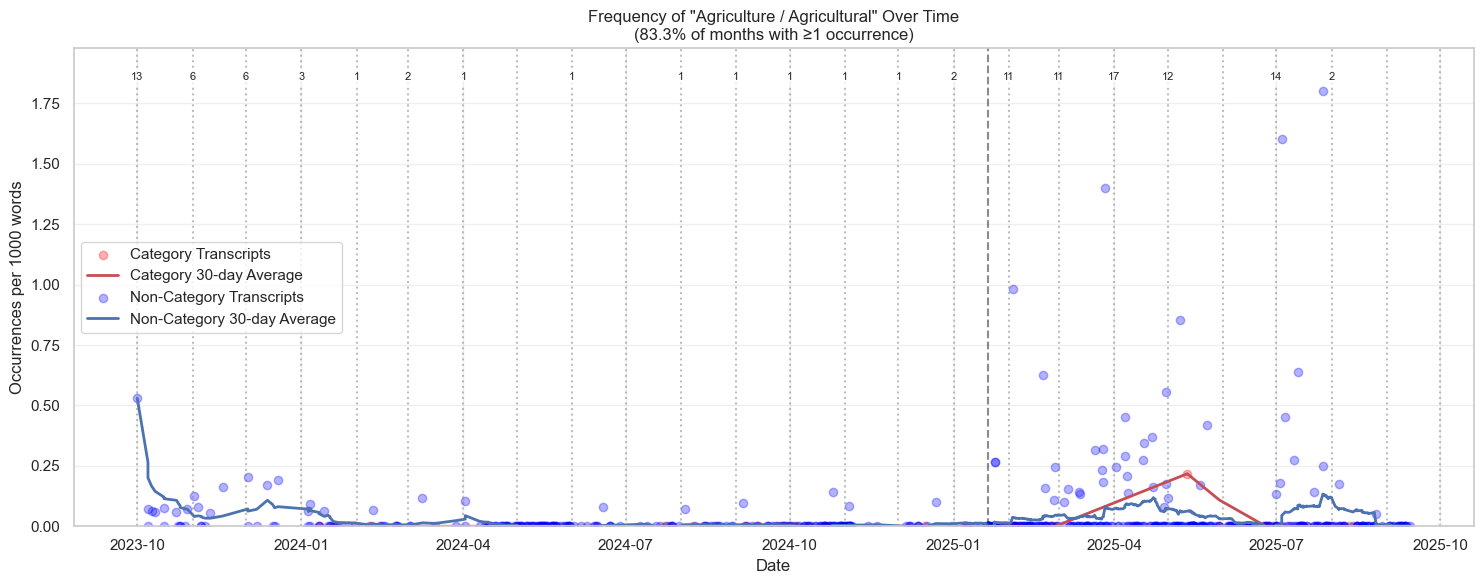


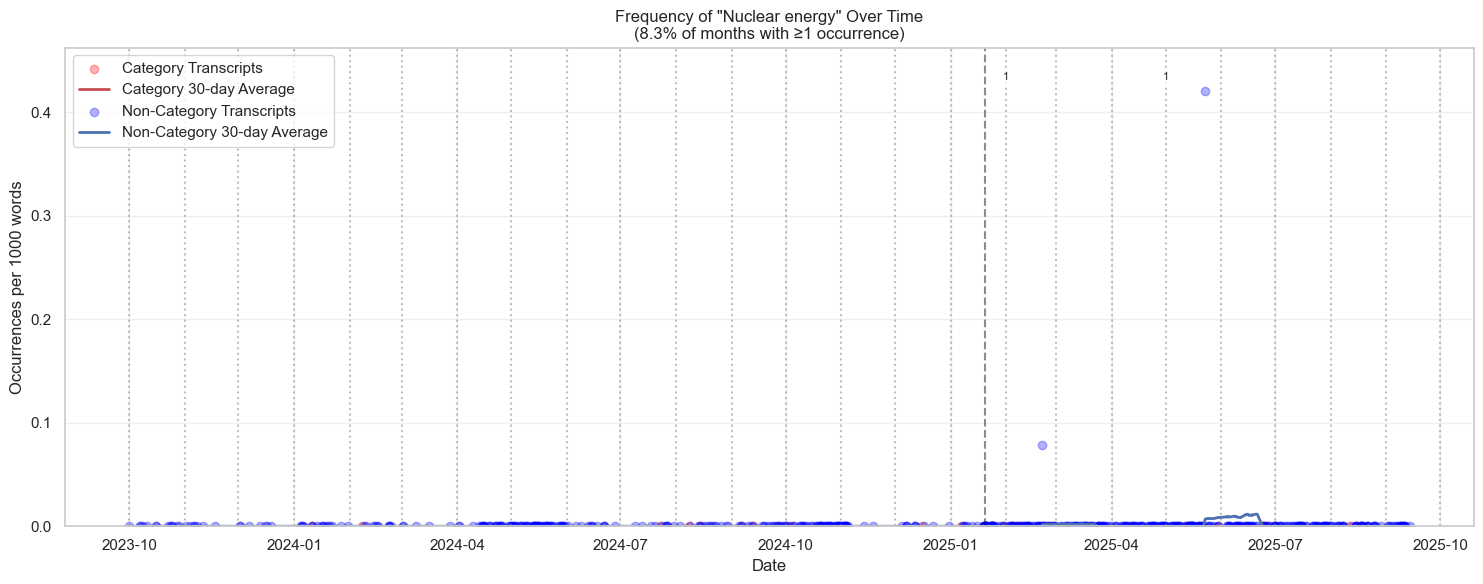

In [85]:
def plot_phrase_frequency_over_time(df_category, df_non_category, phrase, window=30):
    """Plot the frequency of a phrase over time with separate lines for category and non-category"""
    from IPython.display import HTML, display
    
    plt.figure(figsize=(15, 6))
    
    # Filter data to start from October 2023
    start_date = pd.Timestamp('2023-10-01')
    df_category = df_category[df_category['date'] >= start_date].copy()
    df_non_category = df_non_category[df_non_category['date'] >= start_date].copy()
    
    # Process category data
    df_category[f'{phrase}_freq'] = (df_category[phrase] / df_category['text_length']) * 1000
    category_series = df_category.set_index('date')[f'{phrase}_freq']
    category_rolling = category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Process non-category data
    df_non_category[f'{phrase}_freq'] = (df_non_category[phrase] / df_non_category['text_length']) * 1000
    non_category_series = df_non_category.set_index('date')[f'{phrase}_freq']
    non_category_rolling = non_category_series.rolling(window=f'{window}D', min_periods=1).mean()
    
    # Plot category data
    plt.scatter(category_series.index, category_series.values, alpha=0.3, color='red', label='Category Transcripts')
    plt.plot(category_rolling.index, category_rolling.values, 'r-', linewidth=2, label=f'Category {window}-day Average')
    
    # Plot non-category data
    plt.scatter(non_category_series.index, non_category_series.values, alpha=0.3, color='blue', label='Non-Category Transcripts')
    plt.plot(non_category_rolling.index, non_category_rolling.values, 'b-', linewidth=2, label=f'Non-Category {window}-day Average')
    
    plt.title(f'Frequency of "{phrase}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Occurrences per 1000 words')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add vertical line for inauguration
    plt.axvline(x=INAUGURATION_DATE, color='k', linestyle='--', alpha=0.5, label='Inauguration')
    
    # Add monthly vertical lines and counts
    combined_df = pd.concat([df_category, df_non_category])
    if not combined_df.empty:
        date_range = pd.date_range(
            start=combined_df['date'].min().replace(day=1),
            end=combined_df['date'].max() + pd.DateOffset(months=1),
            freq='MS'  # Month start
        )
        
        # Calculate monthly statistics
        combined_df['year_month'] = combined_df['date'].dt.to_period('M')
        monthly_stats = combined_df.groupby('year_month').agg({
            phrase: 'sum',
            'date': 'count'
        }).rename(columns={'date': 'transcript_count'})
        
        # Calculate % of months with 1+ occurrence
        months_with_occurrence = (monthly_stats[phrase] >= 1).sum()
        total_months = len(monthly_stats)
        pct_months_with_occurrence = (months_with_occurrence / total_months * 100) if total_months > 0 else 0
        
        # Add monthly vertical lines and counts
        for date in date_range:
            plt.axvline(x=date, color='gray', linestyle=':', alpha=0.5)
            
            # Get monthly count for this date
            period = date.to_period('M')
            if period in monthly_stats.index:
                monthly_count = monthly_stats.loc[period, phrase]
                if monthly_count > 0:
                    # Position text at top of plot
                    ymax = min(8, max(
                        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
                        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
                    ) * 1.1)
                    plt.text(date, ymax * 0.95, str(int(monthly_count)), 
                            ha='center', va='top', fontsize=8, 
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        # Add percentage to title
        plt.title(f'Frequency of "{phrase}" Over Time\n({pct_months_with_occurrence:.1f}% of months with ≥1 occurrence)')
    
    # Auto-adjust y-axis limit up to max of 8
    ymax = min(8, max(
        df_category[f'{phrase}_freq'].max() if not df_category.empty else 0,
        df_non_category[f'{phrase}_freq'].max() if not df_non_category.empty else 0
    ) * 1.1)  # Add 10% padding
    plt.ylim(0, ymax)
    
    plt.tight_layout()
    
    # Save plot to base64 string for embedding in HTML
    import io
    import base64
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    plot_data = base64.b64encode(buf.read()).decode()
    plt.close()  # Close the figure to free memory
    
    # Create collapsible HTML
    html = f"""
    <details>
        <summary style="cursor: pointer; font-weight: bold; font-size: 14px; padding: 5px;">
            📊 {phrase} - Frequency Over Time
        </summary>
        <div style="margin-top: 10px;">
            <img src="data:image/png;base64,{plot_data}" style="max-width: 100%; height: auto;">
        </div>
    </details>
    """
    
    display(HTML(html))

# Plot time series for all phrases, sorted by frequency
phrase_freqs = {}
for phrase in SEARCH_PHRASES.keys():
    # Calculate average frequency across all data
    category_freq = (df_category[phrase].sum() / df_category['text_length'].sum()) * 1000 if not df_category.empty and df_category['text_length'].sum() > 0 else 0
    non_category_freq = (df_non_category[phrase].sum() / df_non_category['text_length'].sum()) * 1000 if not df_non_category.empty and df_non_category['text_length'].sum() > 0 else 0
    phrase_freqs[phrase] = (category_freq + non_category_freq) / 2

for phrase in phrase_freqs:
    plot_phrase_frequency_over_time(df_category, df_non_category, phrase)

Expected length from category data: 6237 words


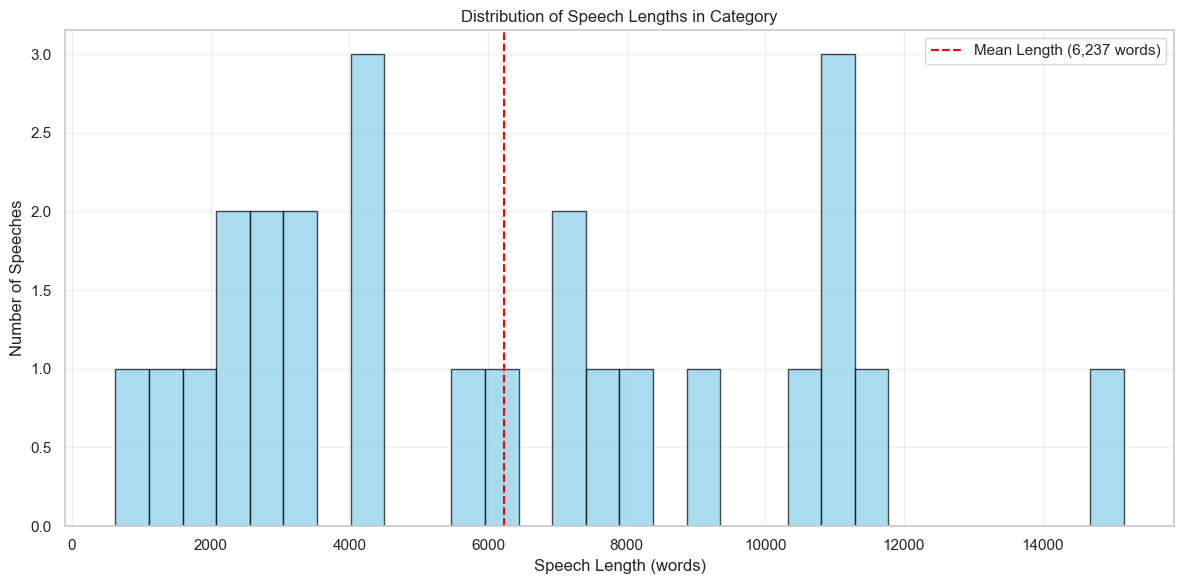

In [98]:
# Calculate expected length from the chosen category
expected_length = df_category['text_length'].mean()
print(f"Expected length from category data: {expected_length:.0f} words")

# Show histogram of category lengths
plt.figure(figsize=(12, 6))
plt.hist(df_category['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=expected_length, color='red', linestyle='--', label=f'Mean Length ({int(expected_length):,} words)')
plt.xlabel('Speech Length (words)')
plt.ylabel('Number of Speeches')
plt.title(f'Distribution of Speech Lengths in Category')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [99]:
# Find all appearances with Keir Starmer and analyze phrase occurrences
starmer_files = df[df['file'].str.contains('keir_starmer', case=False, na=False)]

print(f"Found {len(starmer_files)} files containing 'keir_starmer':")
print()

# Display the file paths to see what we're working with
for idx, row in starmer_files.iterrows():
    print(f"  {row['file']}")

print()

# Create a comprehensive table for all Starmer appearances using existing data
all_starmer_data = []

for idx, row in starmer_files.iterrows():
    filename = row['file']
    word_count = row['text_length']
    
    # Add row for each phrase occurrence
    for phrase in SEARCH_PHRASES.keys():
        count = row[phrase]
        all_starmer_data.append({
            'File': filename,
            'Word Count': word_count,
            'Phrase': phrase,
            'Count': count,
            'Rate per 1000 words': (count / word_count) * 1000 if word_count > 0 else 0
        })
# Create DataFrame and pivot for better display
starmer_df = pd.DataFrame(all_starmer_data)

if not starmer_df.empty:
    # Extract just the date from filename for cleaner display
    starmer_df['Date'] = starmer_df['File'].str.extract(r'(\d{4}-\d{2}-\d{2})')
    
    # Create pivot table with phrases as rows and date/word count as columns
    pivot_df = starmer_df.pivot_table(
        index='Phrase', 
        columns=['Date', 'Word Count'], 
        values='Count', 
        fill_value=0
    )
    
    print("\nPhrase occurrences across all Keir Starmer appearances:")
    display(pivot_df)
    
    # Also show rate per 1000 words
    rate_pivot_df = starmer_df.pivot_table(
        index='Phrase', 
        columns=['Date', 'Word Count'], 
        values='Rate per 1000 words', 
        fill_value=0
    )
    
    print("\nRate per 1000 words across all Keir Starmer appearances:")
    display(rate_pivot_df.style.format('{:.2f}'))
    
    # Summary statistics
    print(f"\nSummary:")
    print(f"Total files processed: {len(pivot_df.columns)}")
    print(f"Total word count: {starmer_files['text_length'].sum():,}")
    
else:
    print("\nNo data found for Keir Starmer appearances.")


Found 5 files containing 'keir_starmer':

  2025-02-27_donald_trump_holds_a_bilat_with_keir_starmer_of_the_united_kingdom.txt
  2025-02-27_donald_trump_and_keir_starmer_of_the_united_kingdom_hold_a_press_event.txt
  2025-06-16_donald_trump_holds_a_bilat_with_keir_starmer_of_the_united_kingdom.txt
  2025-07-28_donald_trump_welcomes_keir_starmer_of_the_united_kingdom_to_trump_turnberry.txt
  2025-07-28_donald_trump_holds_a_bilat_with_keir_starmer_of_the_united_kingdom.txt


Phrase occurrences across all Keir Starmer appearances:


Date                             2025-02-27       2025-06-16 2025-07-28      
Word Count                             2868  4073       698        2276  9593
Phrase                                                                       
Agriculture / Agricultural              0.0   1.0        0.0        0.0   0.0
Biden                                   2.0   5.0        1.0        0.0   3.0
Buckingham / Windsor                    0.0   1.0        0.0        0.0   2.0
Carriage                                0.0   0.0        0.0        0.0   0.0
Charlie                                 0.0   0.0        0.0        0.0   0.0
Churchill                               1.0   0.0        0.0        0.0   0.0
Energy                                  0.0   0.0        0.0        0.0   7.0
Europe / European                       3.0   2.0        2.0        3.0  10.0
Gaza / Israel                           2.0   1.0        1.0        6.0  11.0
Golf                                    0.0   0.0        0.0        0.0   0.0
Hamas                                   0.0   0.0        0.0        3.0   7.0
Immigration / Migration                 0.0   0.0        0.0        4.0   9.0
King                                    3.0   2.0        0.0        0.0   3.0
London                                  0.0   0.0        0.0        0.0   2.0
NATO                                    2.0   3.0        0.0        0.0   5.0
Nuclear                                 0.0   0.0        1.0        5.0   6.0
Nuclear energy                          0.0   0.0        0.0        0.0   0.0
Pharmaceutical                          1.0   0.0        0.0        0.0   8.0
Putin                                   1.0   4.0        0.0        3.0   4.0
Queen                                   0.0   0.0        0.0        0.0   3.0
Russia / Ukraine                       14.0  15.0        2.0        0.0  12.0
Sanction                                0.0   0.0        3.0        0.0   2.0
Scotch / Whisky                         0.0   0.0        0.0        0.0   0.0
Tariff                                  8.0   6.0        0.0        0.0   4.0
Trade Deal                              3.0   0.0        0.0        7.0   8.0
Zelenskyy / Zelensky / Zelenskiy        2.0   4.0        0.0        0.0   0.0


Rate per 1000 words across all Keir Starmer appearances:



Summary:
Total files processed: 5
Total word count: 19,508


## Poisson Predictions

The most naive approach is to use the past frequency of a phrase over a given time period to forecast the probability of a phrase occurring during the expected length of a future speech. Using the Poisson distribution, we assume each word is independent and identically distributed. This allows us to compute threshold probabilities for a phrase occurring a given number of times, which can be compared to the prediction market's implied probability. However, this approach does not account for the clear dependence between words in a speech. This approach can still be useful for analyzing mentions where mostly independent occurrences might be expected (America, God, etc.) 

In [88]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with likelihoods using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate likelihoods using Poisson PMF
        def poisson_ge_k(lambda_, k):
            return 1 - stats.poisson.cdf(k-1, lambda_)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences,
            'P(≥1)': poisson_ge_k(expected, 1),
            'P(≥3)': poisson_ge_k(expected, 3),
            'P(≥4)': poisson_ge_k(expected, 4),
            'P(≥5)': poisson_ge_k(expected, 5),
            'P(≥15)': poisson_ge_k(expected, 15)
        })
    
    return pd.DataFrame(predictions)

In [89]:


length = 600

# Calculate predictions from different data sources
predictions_all = calculate_poisson_predictions(df, length)
predictions_speeches = calculate_poisson_predictions(df_category, length)
predictions_post_all = calculate_poisson_predictions(pd.concat([df_category_pre, df_category_post]), length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['P(≥1)'] = formatted['P(≥1)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥3)'] = formatted['P(≥3)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥4)'] = formatted['P(≥4)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥5)'] = formatted['P(≥5)'].apply(lambda x: f"{x:.1%}")
    formatted['P(≥15)'] = formatted['P(≥15)'].apply(lambda x: f"{x:.1%}")
    
    return formatted[[
        'Phrase', 'Expected',
        'P(≥1)', 'P(≥3)', 'P(≥4)', 'P(≥5)', 'P(≥15)',
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on all appearances:")
display(format_prediction_table(predictions_all, 'all'))

print("\nPredictions based on all speeches:")
display(format_prediction_table(predictions_speeches, 'post-inauguration-speeches'))

print("\nPredictions based on all post-inauguration appearances:")
display(format_prediction_table(predictions_post_all, 'post-inauguration-all'))

Predictions based on all appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
23,Biden,0.80,55.0%,5.0%,1.0%,0.0%,0.0%,1.33,4389
6,Russia / Ukraine,0.53,41.0%,2.0%,0.0%,0.0%,0.0%,0.88,2900
3,Tariff,0.41,34.0%,1.0%,0.0%,0.0%,0.0%,0.68,2252
18,Energy,0.33,28.0%,0.0%,0.0%,0.0%,0.0%,0.55,1807
16,Gaza / Israel,0.21,19.0%,0.0%,0.0%,0.0%,0.0%,0.35,1165
9,Nuclear,0.16,15.0%,0.0%,0.0%,0.0%,0.0%,0.27,896
17,Europe / European,0.16,15.0%,0.0%,0.0%,0.0%,0.0%,0.27,880
8,Putin,0.12,11.0%,0.0%,0.0%,0.0%,0.0%,0.20,650
10,NATO,0.07,7.0%,0.0%,0.0%,0.0%,0.0%,0.12,410
14,Hamas,0.05,5.0%,0.0%,0.0%,0.0%,0.0%,0.09,302



Predictions based on all speeches:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
6,Russia / Ukraine,0.88,59.0%,6.0%,1.0%,0.0%,0.0%,1.47,230
23,Biden,0.53,41.0%,2.0%,0.0%,0.0%,0.0%,0.89,139
3,Tariff,0.38,32.0%,1.0%,0.0%,0.0%,0.0%,0.64,100
16,Gaza / Israel,0.28,24.0%,0.0%,0.0%,0.0%,0.0%,0.46,72
9,Nuclear,0.27,24.0%,0.0%,0.0%,0.0%,0.0%,0.45,70
17,Europe / European,0.23,20.0%,0.0%,0.0%,0.0%,0.0%,0.38,59
18,Energy,0.20,18.0%,0.0%,0.0%,0.0%,0.0%,0.33,52
8,Putin,0.20,18.0%,0.0%,0.0%,0.0%,0.0%,0.33,52
10,NATO,0.15,14.0%,0.0%,0.0%,0.0%,0.0%,0.25,39
1,Zelenskyy / Zelensky / Zelenskiy,0.12,11.0%,0.0%,0.0%,0.0%,0.0%,0.19,30



Predictions based on all post-inauguration appearances:


,Phrase,Expected,P(≥1),P(≥3),P(≥4),P(≥5),P(≥15),Historical Rate,Total Historical
6,Russia / Ukraine,0.88,59.0%,6.0%,1.0%,0.0%,0.0%,1.47,230
23,Biden,0.53,41.0%,2.0%,0.0%,0.0%,0.0%,0.89,139
3,Tariff,0.38,32.0%,1.0%,0.0%,0.0%,0.0%,0.64,100
16,Gaza / Israel,0.28,24.0%,0.0%,0.0%,0.0%,0.0%,0.46,72
9,Nuclear,0.27,24.0%,0.0%,0.0%,0.0%,0.0%,0.45,70
17,Europe / European,0.23,20.0%,0.0%,0.0%,0.0%,0.0%,0.38,59
18,Energy,0.20,18.0%,0.0%,0.0%,0.0%,0.0%,0.33,52
8,Putin,0.20,18.0%,0.0%,0.0%,0.0%,0.0%,0.33,52
10,NATO,0.15,14.0%,0.0%,0.0%,0.0%,0.0%,0.25,39
1,Zelenskyy / Zelensky / Zelenskiy,0.12,11.0%,0.0%,0.0%,0.0%,0.0%,0.19,30


## Negative Binomial 

A more general model that accounts for overdispersion. The dispersion parameter r is estimated using the method of moments, and it controls how much extra variance there is compared to a Poisson distribution. As r approaches infinity, the negative binomial converges to a Poisson distribution (in practice we use r=100 to approximate this). Values closer to 0 indicate that the data is overdispersed.

In [100]:
foreign_engagements = ['2024-07-26_donald_trump_meets_with_benjamin_netanyahu_of_israel_at_mar-a-lago.txt',
'2024-12-07_donald_trump_meets_with_emmanuel_macron_of_france_in_paris.txt',
'2024-12-07_donald_trump_meets_with_william_prince_of_wales_in_paris.txt',
'2025-02-04_donald_trump_holds_a_presser_with_benjamin_netanyahu_of_israel.txt',
'2025-02-04_donald_trump_holds_a_bilat_with_benjamin_netanyahu_of_israel.txt',
'2025-02-07_donald_trump_holds_a_bilateral_meeting_with_shigeru_ishiba_of_japan.txt',
'2025-02-11_donald_trump_holds_a_bilateral_meeting_with_king_abdullah_ii_of_jordan.txt',
'2025-02-13_donald_trump_holds_a_bilateral_meeting_with_narendra_modi_of_india.txt',
'2025-02-24_donald_trump_holds_a_bilateral_meeting_with_emmanuel_macron_of_france.txt',
'2025-02-27_donald_trump_holds_a_bilat_with_keir_starmer_of_the_united_kingdom.txt',
'2025-02-28_donald_trump_holds_a_bilat_with_volodymyr_zelenskyy_of_ukraine.txt',
'2025-03-12_donald_trump_holds_a_bilateral_meeting_with_micheál_martin_of_ireland.txt',
'2025-03-13_donald_trump_holds_a_bilateral_meeting_with_mark_rutte_of_nato.txt',
'2025-04-07_donald_trump_holds_a_bilat_with_benjamin_netanyahu_of_israel.txt',
'2025-04-14_donald_trump_holds_a_bilateral_meeting_with_nayib_bukele_of_el_salvador.txt',
'2025-04-17_donald_trump_holds_a_bilat_with_giorgia_meloni_of_italy.txt',
'2025-04-24_donald_trump_holds_a_bilateral_lunch_with_jonas_gahr_støre_of_norway.txt',
'2025-04-24_donald_trump_holds_a_bilateral_meeting_with_jonas_gahr_støre_of_norway.txt',
'2025-05-06_donald_trump_holds_a_bilateral_meeting_with_mark_carney_of_canada.txt',
'2025-05-15_donald_trump_holds_a_bilat_with_sheikh_al_nahyan_in_abu_dhabi.txt',
'2025-05-21_donald_trump_holds_a_bilat_with_cyril_ramaphosa_of_south_africa.txt',
'2025-06-05_donald_trump_holds_a_bilat_with_friedrich_merz_of_germany.txt',
'2025-06-05_donald_trump_welcomes_friedrich_merz_of_germany_to_the_white_house.txt',
'2025-06-16_donald_trump_holds_a_bilat_with_keir_starmer_of_the_united_kingdom.txt',
'2025-06-16_donald_trump_holds_a_bilateral_meeting_with_mark_carney_of_canada_at_the_g7.txt',
'2025-06-25_donald_trump_holds_a_pull-aside_bilat_with_mark_rutte_of_nato.txt',
'2025-06-25_donald_trump_holds_a_bilat_with_dick_schoof_of_the_netherlands.txt',
'2025-06-27_donald_trump_meets_with_foreign_ministers_from_drc_and_rwanda.txt',
'2025-07-07_donald_trump_holds_a_bilateral_dinner_with_benjamin_netanyahu_of_israel.txt',
'2025-07-09_donald_trump_meets_with_the_leaders_of_five_african_nations_over_lunch.txt',
'2025-07-14_donald_trump_holds_a_bilateral_meeting_with_mark_rutte_of_nato.txt',
'2025-07-16_donald_trump_holds_a_bilat_with_salman_bin_hamad_al_khalifa_of_bahrain.txt',
'2025-07-22_donald_trump_welcomes_bongbong_marcos_to_the_white_house.txt',
'2025-07-22_donald_trump_holds_a_bilat_with_bongbong_marcos_of_the_philippines.txt',
'2025-07-27_donald_trump_holds_a_bilateral_meeting_with_ursula_von_der_leyen_of_the_eu.txt',
'2025-07-28_donald_trump_holds_a_bilat_with_keir_starmer_of_the_united_kingdom.txt',
'2025-07-28_donald_trump_welcomes_keir_starmer_of_the_united_kingdom_to_trump_turnberry.txt',
'2025-08-08_donald_trump_welcomes_nikol_pashinyan_of_armenia_to_the_white_house.txt',
'2025-08-08_donald_trump_welcomes_ilham_aliyev_of_azerbaijan_to_the_white_house.txt',
'2025-08-15_donald_trump_holds_a_bilateral_meeting_with_vladimir_putin_of_russia.txt',
'2025-08-18_donald_trump_holds_a_bilat_with_volodymyr_zelenskyy_of_ukraine.txt',
'2025-08-18_donald_trump_meets_with_european_leaders_on_ukraine.txt',
'2025-08-18_donald_trump_welcomes_volodymyr_zelenskyy_to_the_white_house.txt']

In [101]:

def calculate_negative_binomial_predictions(df, avg_length):
    """Calculate predictions using Negative Binomial distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Skip phrases that don't exist in the dataframe
        if phrase not in df.columns:
            continue
            
        # Calculate rate per word and variance
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in speech of avg_length
        expected = rate_per_word * avg_length
        
        # Calculate sample variance to estimate overdispersion
        counts_per_speech = df[phrase] / df['text_length'] * avg_length
        sample_variance = counts_per_speech.var()
        
        if sample_variance > expected and expected > 0:  # Check for overdispersion
            # Calculate r parameter for negative binomial using method of moments
            r = max(0.1, expected**2 / (sample_variance - expected))
            p = r/(r + expected)
        else:
            # If no overdispersion, fallback to quasi-Poisson
            r = 100
            p = r/(r + expected)
        
        # Calculate likelihoods using Negative Binomial CDF
        def nb_ge_k(r, p, k):
            return 1 - stats.nbinom.cdf(k-1, r, p)
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Dispersion (r)': r,
            'Sample Variance': sample_variance,
            'P(≥1)': nb_ge_k(r, p, 1)
        })
    
    return pd.DataFrame(predictions)


def format_prediction_table(df):
    """Format prediction table with percentages"""
    formatted = df.copy()
    formatted = formatted.round(3)
    
    # Format probability columns as percentages
    formatted['P(≥1)'] = formatted['P(≥1)'].map('{:.1%}'.format)
    
    # Round other numeric columns
    formatted['Expected'] = formatted['Expected'].round(2)
    if 'Dispersion (r)' in formatted.columns:
        formatted['Dispersion (r)'] = formatted['Dispersion (r)'].round(2)
        formatted['Sample Variance'] = formatted['Sample Variance'].round(2)
    
    return formatted.sort_values('Expected', ascending=False)

def compare_models(poisson_df, nb_df):
    """Compare Poisson and Negative Binomial predictions"""
    comparison = pd.DataFrame()
    comparison['Phrase'] = poisson_df['Phrase']
    comparison['Expected'] = poisson_df['Expected']
    
    # Convert percentage strings back to floats for calculations
    comparison['Poisson P(≥1)'] = poisson_df['P(≥1)'].astype(float)
    comparison['NB P(≥1)'] = nb_df['P(≥1)'].astype(float)
    comparison['Δ P(≥1)'] = (comparison['NB P(≥1)'] - comparison['Poisson P(≥1)']) * 100
    
    comparison['Dispersion (r)'] = nb_df['Dispersion (r)']
    comparison['Sample Variance'] = nb_df['Sample Variance']
    
    # Format probability columns as percentages
    comparison['Poisson P(≥1)'] = comparison['Poisson P(≥1)'].map('{:.1%}'.format)
    comparison['NB P(≥1)'] = comparison['NB P(≥1)'].map('{:.1%}'.format)
    
    return comparison.round(3).sort_values('Δ P(≥1)', ascending=True)

def plot_distribution_comparison(phrase, poisson_df, nb_df, max_k=10):
    """Plot comparison of Poisson and Negative Binomial distributions"""
    phrase_data = poisson_df[poisson_df['Phrase'] == phrase].iloc[0]
    nb_data = nb_df[nb_df['Phrase'] == phrase].iloc[0]
    
    lambda_ = phrase_data['Expected']
    r = nb_data['Dispersion (r)']
    p = r/(r + lambda_)
    
    k = np.arange(0, max_k+1)
    poisson_pmf = stats.poisson.pmf(k, lambda_)
    nb_pmf = stats.nbinom.pmf(k, r, p)
    
    plt.figure(figsize=(10, 6))
    plt.bar(k-0.2, poisson_pmf, width=0.4, alpha=0.5, label='Poisson', color='blue')
    plt.bar(k+0.2, nb_pmf, width=0.4, alpha=0.5, label='Negative Binomial', color='red')
    plt.title(f'Distribution Comparison for "{phrase}"')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Calculate predictions using both models
avg_speech_length = df_category['text_length'].mean()
print(f"Avg speech length: {avg_speech_length:.0f} words")

print("Negative Binomial Predictions based on all appearances:")
nb_predictions = calculate_negative_binomial_predictions(df, avg_speech_length)
display(format_prediction_table(nb_predictions))

print("Negative Binomial Predictions based on category:")
nb_predictions = calculate_negative_binomial_predictions(df_category, avg_speech_length)
display(format_prediction_table(nb_predictions))

# Filter for foreign engagements only
df_foreign = df[df['file'].isin(foreign_engagements)]
print("Negative Binomial Predictions based on foreign engagements only:")
nb_predictions_foreign = calculate_negative_binomial_predictions(df_foreign, avg_speech_length)
display(format_prediction_table(nb_predictions_foreign))

print("Negative Binomial Predictions based on all appearances post inauguration:")
nb_predictions_all = calculate_negative_binomial_predictions(df_post, avg_speech_length)
display(format_prediction_table(nb_predictions_all))

poisson_predictions = calculate_poisson_predictions(df_category_post, avg_speech_length)

print("\nModel Comparison (Negative Binomial vs Poisson):")
display(compare_models(poisson_predictions, nb_predictions))

# Plot distributions for most overdispersed phrases - only use phrases that exist in the data
available_phrases = ['Border', 'America', 'God', 'Rigged', 'Hell']
most_overdispersed = nb_predictions[nb_predictions['Phrase'].isin(available_phrases)]
for _, row in most_overdispersed.iterrows():
    # Get parameters for both distributions
    phrase_data = poisson_predictions[poisson_predictions['Phrase'] == row['Phrase']].iloc[0]
    lambda_ = phrase_data['Expected']
    r = row['Dispersion (r)']
    p = r/(r + lambda_)
    
    # Find where probability becomes negligible (< 0.1%)
    k = 0
    while stats.nbinom.pmf(k, r, p) > 0.001 or stats.poisson.pmf(k, lambda_) > 0.001:
        k += 1
    
    # Ensure minimum k of 30 for 'America' to show full distribution
    if row['Phrase'] == 'America':
        k = max(k, 60)
    
    print(f"\nDistribution comparison for {row['Phrase']} (r = {row['Dispersion (r)']:.2f}):")
    plot_distribution_comparison(row['Phrase'], poisson_predictions, nb_predictions, max_k=k)

Avg speech length: 6237 words
Negative Binomial Predictions based on all appearances:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
23,Biden,8.30,0.66,113.25,82.0%
6,Russia / Ukraine,5.48,0.48,67.97,70.2%
3,Tariff,4.26,0.37,53.78,60.5%
18,Energy,3.42,0.66,20.99,70.0%
16,Gaza / Israel,2.20,0.10,67.32,26.9%
9,Nuclear,1.69,0.17,18.58,33.4%
17,Europe / European,1.66,0.16,18.95,32.3%
8,Putin,1.23,0.18,9.83,30.6%
10,NATO,0.78,0.10,9.22,19.5%
14,Hamas,0.57,0.10,8.54,17.3%


Negative Binomial Predictions based on category:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
6,Russia / Ukraine,9.20,0.40,219.22,72.1%
23,Biden,5.56,0.36,91.82,63.4%
3,Tariff,4.00,0.52,34.67,67.6%
16,Gaza / Israel,2.88,0.17,50.51,39.3%
9,Nuclear,2.80,0.48,19.29,60.0%
17,Europe / European,2.36,0.41,15.88,54.4%
18,Energy,2.08,1.36,5.25,71.7%
8,Putin,2.08,0.11,40.64,28.4%
10,NATO,1.56,0.28,10.20,41.1%
1,Zelenskyy / Zelensky / Zelenskiy,1.20,0.25,6.98,35.5%


Negative Binomial Predictions based on foreign engagements only:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
6,Russia / Ukraine,10.74,1.22,105.18,93.8%
16,Gaza / Israel,6.78,0.25,189.50,56.7%
17,Europe / European,6.48,1.03,47.15,87.1%
3,Tariff,6.39,1.17,41.25,88.7%
23,Biden,6.29,1.01,45.38,86.5%
10,NATO,4.02,0.71,26.68,74.0%
9,Nuclear,3.44,0.57,24.02,67.2%
8,Putin,3.39,0.50,26.30,64.2%
18,Energy,2.95,0.53,19.47,63.0%
2,Trade Deal,1.79,0.27,13.61,42.3%


Negative Binomial Predictions based on all appearances post inauguration:


,Phrase,Expected,Dispersion (r),Sample Variance,P(≥1)
3,Tariff,7.34,0.74,79.79,83.1%
6,Russia / Ukraine,6.16,0.40,101.12,67.4%
23,Biden,5.14,0.91,34.14,82.2%
17,Europe / European,3.13,0.36,30.46,55.8%
18,Energy,2.64,0.32,24.47,51.0%
9,Nuclear,2.24,0.19,28.25,38.6%
16,Gaza / Israel,2.16,0.10,74.42,26.8%
8,Putin,1.77,0.22,15.63,38.8%
10,NATO,1.56,0.28,10.42,40.7%
14,Hamas,0.78,0.10,13.35,19.6%



Model Comparison (Negative Binomial vs Poisson):


,Phrase,Expected,Poisson P(≥1),NB P(≥1),Δ P(≥1),Dispersion (r),Sample Variance
8,Putin,3.018,95.1%,28.4%,-66.753,0.112,40.639
16,Gaza / Israel,4.665,99.1%,39.3%,-59.784,0.174,50.512
14,Hamas,1.555,78.9%,21.4%,-57.507,0.109,7.981
1,Zelenskyy / Zelensky / Zelenskiy,2.012,86.6%,35.5%,-51.132,0.249,6.984
10,NATO,2.378,90.7%,41.1%,-49.655,0.282,10.200
0,Pharmaceutical,1.098,66.6%,17.7%,-48.896,0.123,2.358
12,King,1.189,69.6%,21.8%,-47.709,0.147,3.431
17,Europe / European,4.208,98.5%,54.4%,-44.109,0.412,15.881
2,Trade Deal,1.098,66.6%,23.2%,-43.463,0.168,3.083
9,Nuclear,5.031,99.3%,60.0%,-39.297,0.475,19.292


## Recent Usage in context

In [92]:
def get_recent_contexts(df, phrase, n=5):
    """Get the n most recent contexts for a phrase"""
    # Create a list to store matches with their dates
    all_matches = []
    
    # Look through speeches from newest to oldest
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({
                'date': row['date'],
                'category': row['category'],
                'context': match
            })
        if len(all_matches) >= n:
            break
    
    return pd.DataFrame(all_matches[:n])

# Get recent contexts for each phrase
for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['category']})")
            print(f"Context: {row['context']}\n")


=== Recent usage of 'Pharmaceutical' ===



Date: 2025-08-05 (interview)
Context: ...u want to pay 1% tariffs.

You wanted 1%." I said, "You're not going to pay 1%." We don't lose -- because I view deficit as loss -- you know, you have some people, by the way, I --

Well I'll go into pharmaceuticals. They make a fortune with pharmaceuticals. And they make our pharmaceuticals in China and Ireland and everything else. And within the next week or so, we're going to be announcing tariffs on specifica...

Date: 2025-08-05 (interview)
Context: ... I said, "You're not going to pay 1%." We don't lose -- because I view deficit as loss -- you know, you have some people, by the way, I --

Well I'll go into pharmaceuticals. They make a fortune with pharmaceuticals. And they make our pharmaceuticals in China and Ireland and everything else. And within the next week or so, we're going to be announcing tariffs on specifically, this is a, you know, this is a separa...

Date: 2025-08-05 (interview)
Context: ...%." We don't lose -- because I vie

## Per-Speech Frequencies


In [93]:
len(foreign_engagements)

43

In [94]:
# Calculate percentage of appearances containing each phrase at least once
phrase_percentages = {}

# Filter for appearances since May 1
df_since_may = df[df['date'] >= '2025-05-01']

# Filter for foreign engagements
df_foreign = df[df['file'].isin(foreign_engagements)]
min_words = 100
max_words = 100000
# Filter out foreign engagements with less than x words
df_foreign_filtered = df_foreign[(df_foreign['text_length'] >= min_words) & (df_foreign['text_length'] <= max_words)]
filtered_out = df_foreign[(df_foreign['text_length'] < min_words) | (df_foreign['text_length'] > max_words)]

if len(filtered_out) > 0:
    print(f"Filtered out {len(filtered_out)} foreign engagements with less than {min_words} words or more than {max_words} words:")
    for _, row in filtered_out.iterrows():
        print(f"  - {row['file']} ({row['text_length']} words)")
    print()

# Update df_foreign to use the filtered version
df_foreign = df_foreign_filtered


for phrase in SEARCH_PHRASES.keys():
    all_pct = (df[phrase] >= 1).mean() * 100
    speech_pct = (df_category[phrase] >= 1).mean() * 100
    post_pct = (df_post[phrase] >= 1).mean() * 100
    since_may_pct = (df_since_may[phrase] >= 1).mean() * 100 if len(df_since_may) > 0 else 0
    foreign_pct = (df_foreign[phrase] >= 1).mean() * 100 if len(df_foreign) > 0 else 0
    phrase_percentages[phrase] = {
        'All Appearances': all_pct,
        f'{CATEGORY_OF_INTEREST} Only': speech_pct, 
        'Post-Inauguration': post_pct,
        'Since May 1': since_may_pct,
        'Foreign Engagements': foreign_pct
    }

# Create DataFrame and sort by percentage in all appearances
phrase_df = pd.DataFrame.from_dict(phrase_percentages, orient='index')
phrase_df = phrase_df.sort_values('All Appearances', ascending=False)
phrase_df.index.name = 'Phrase'

# Format table for display
styled_df = phrase_df.style.format({
    'All Appearances': '{:.1f}%'.format,
    f'{CATEGORY_OF_INTEREST} Only': '{:.1f}%'.format,
    'Post-Inauguration': '{:.1f}%'.format,
    'Since May 1': '{:.1f}%'.format,
    'Foreign Engagements': '{:.1f}%'.format
})

print("Percentage of Appearances Containing Each Phrase:")
display(styled_df)


Filtered out 7 foreign engagements with less than 100 words or more than 100000 words:
  - 2024-12-07_donald_trump_meets_with_william_prince_of_wales_in_paris.txt (39 words)
  - 2025-06-05_donald_trump_welcomes_friedrich_merz_of_germany_to_the_white_house.txt (15 words)
  - 2025-07-22_donald_trump_welcomes_bongbong_marcos_to_the_white_house.txt (27 words)
  - 2025-08-08_donald_trump_welcomes_nikol_pashinyan_of_armenia_to_the_white_house.txt (4 words)
  - 2025-08-08_donald_trump_welcomes_ilham_aliyev_of_azerbaijan_to_the_white_house.txt (9 words)
  - 2025-08-15_donald_trump_holds_a_bilateral_meeting_with_vladimir_putin_of_russia.txt (10 words)
  - 2025-08-18_donald_trump_welcomes_volodymyr_zelenskyy_to_the_white_house.txt (11 words)

Percentage of Appearances Containing Each Phrase:


,All Appearances,press conference Only,Post-Inauguration,Since May 1,Foreign Engagements
Phrase,,,,,
Biden,70.4%,88.0%,60.8%,55.7%,75.0%
Russia / Ukraine,60.2%,88.0%,54.5%,48.5%,80.6%
Tariff,51.8%,52.0%,52.9%,46.9%,55.6%
Energy,45.6%,32.0%,33.2%,32.5%,38.9%
Gaza / Israel,44.6%,56.0%,34.0%,35.1%,58.3%
Putin,39.8%,56.0%,35.3%,35.6%,55.6%
Europe / European,39.0%,52.0%,41.4%,42.8%,63.9%
Nuclear,35.9%,44.0%,29.6%,35.6%,52.8%
Immigration / Migration,22.0%,28.0%,9.3%,10.3%,19.4%


foreign leader meeting keywords:
welcomes, greets, bilat, bilateral, meets,


In [95]:
# Filter for foreign leader meetings based on filename keywords
foreign_leader_keywords = ['welcomes', 'greets', 'bilat', 'bilateral', 'meets']

# Get all transcripts with filenames containing foreign leader keywords
foreign_leader_df = df[df['file'].str.contains('|'.join(foreign_leader_keywords), case=False, na=False)]

print(f"Found {len(foreign_leader_df)} foreign leader meeting transcripts:")
print("\nForeign Leader Meeting Transcripts:")
for idx, row in foreign_leader_df.iterrows():
    print(f"Date: {row['date'].strftime('%Y-%m-%d')} - {row['file']}")
    print(f"Category: {row['category']}")
    print()

# Filter for press conference transcripts based on filename keywords
press_conference_keywords = ['press_conference', 'presser', 'news_conference']

# Get all transcripts with filenames containing press conference keywords
press_conference_df = df[df['file'].str.contains('|'.join(press_conference_keywords), case=False, na=False)]

print(f"Found {len(press_conference_df)} press conference transcripts:")
print("\nPress Conference Transcripts:")
for idx, row in press_conference_df.iterrows():
    print(f"Date: {row['date'].strftime('%Y-%m-%d')} - {row['file']}")
    print(f"Category: {row['category']}")
    print()

# Combine foreign leader meetings and press conferences
combined_df = pd.concat([foreign_leader_df, press_conference_df]).drop_duplicates()

print(f"\nCombined list ({len(combined_df)} total transcripts):")
print("=" * 80)
for idx, row in combined_df.sort_values('date').iterrows():
    print(f"'{row['file']}',")



Found 56 foreign leader meeting transcripts:

Foreign Leader Meeting Transcripts:
Date: 2024-07-26 - 2024-07-26_donald_trump_meets_with_benjamin_netanyahu_of_israel_at_mar-a-lago.txt
Category: press gaggle

Date: 2024-12-07 - 2024-12-07_donald_trump_meets_with_william_prince_of_wales_in_paris.txt
Category: remarks

Date: 2024-12-07 - 2024-12-07_donald_trump_meets_with_emmanuel_macron_of_france_in_paris.txt
Category: remarks

Date: 2025-02-03 - 2025-02-03_donald_trump_welcomes_the_champion_florida_panthers_to_the_white_house.txt
Category: remarks

Date: 2025-02-04 - 2025-02-04_donald_trump_holds_a_bilat_with_benjamin_netanyahu_of_israel.txt
Category: remarks

Date: 2025-02-07 - 2025-02-07_donald_trump_holds_a_bilateral_meeting_with_shigeru_ishiba_of_japan.txt
Category: remarks

Date: 2025-02-11 - 2025-02-11_donald_trump_greets_marc_fogel_after_his_release_from_russia.txt
Category: remarks

Date: 2025-02-11 - 2025-02-11_donald_trump_holds_a_bilateral_meeting_with_king_abdullah_ii_of_jord

In [96]:
foreign_engagements = ['2024-07-26_donald_trump_meets_with_benjamin_netanyahu_of_israel_at_mar-a-lago.txt',
'2024-12-07_donald_trump_meets_with_emmanuel_macron_of_france_in_paris.txt',
'2024-12-07_donald_trump_meets_with_william_prince_of_wales_in_paris.txt',
'2025-02-04_donald_trump_holds_a_presser_with_benjamin_netanyahu_of_israel.txt',
'2025-02-04_donald_trump_holds_a_bilat_with_benjamin_netanyahu_of_israel.txt',
'2025-02-07_donald_trump_holds_a_bilateral_meeting_with_shigeru_ishiba_of_japan.txt',
'2025-02-11_donald_trump_holds_a_bilateral_meeting_with_king_abdullah_ii_of_jordan.txt',
'2025-02-11_donald_trump_greets_marc_fogel_after_his_release_from_russia.txt',
'2025-02-13_donald_trump_holds_a_bilateral_meeting_with_narendra_modi_of_india.txt',
'2025-02-24_donald_trump_holds_a_bilateral_meeting_with_emmanuel_macron_of_france.txt',
'2025-02-27_donald_trump_holds_a_bilat_with_keir_starmer_of_the_united_kingdom.txt',
'2025-02-28_donald_trump_holds_a_bilat_with_volodymyr_zelenskyy_of_ukraine.txt',
'2025-03-12_donald_trump_holds_a_bilateral_meeting_with_micheál_martin_of_ireland.txt',
'2025-03-13_donald_trump_holds_a_bilateral_meeting_with_mark_rutte_of_nato.txt',
'2025-03-25_donald_trump_meets_with_us_ambassadors_at_the_white_house.txt',
'2025-04-07_donald_trump_holds_a_bilat_with_benjamin_netanyahu_of_israel.txt',
'2025-04-14_donald_trump_holds_a_bilateral_meeting_with_nayib_bukele_of_el_salvador.txt',
'2025-04-17_donald_trump_holds_a_bilat_with_giorgia_meloni_of_italy.txt',
'2025-04-24_donald_trump_holds_a_bilateral_lunch_with_jonas_gahr_støre_of_norway.txt',
'2025-04-24_donald_trump_holds_a_bilateral_meeting_with_jonas_gahr_støre_of_norway.txt',
'2025-05-06_donald_trump_holds_a_bilateral_meeting_with_mark_carney_of_canada.txt',
'2025-05-15_donald_trump_holds_a_bilat_with_sheikh_al_nahyan_in_abu_dhabi.txt',
'2025-05-21_donald_trump_holds_a_bilat_with_cyril_ramaphosa_of_south_africa.txt',
'2025-06-05_donald_trump_holds_a_bilat_with_friedrich_merz_of_germany.txt',
'2025-06-05_donald_trump_welcomes_friedrich_merz_of_germany_to_the_white_house.txt',
'2025-06-16_donald_trump_holds_a_bilat_with_keir_starmer_of_the_united_kingdom.txt',
'2025-06-16_donald_trump_holds_a_bilateral_meeting_with_mark_carney_of_canada_at_the_g7.txt',
'2025-06-25_donald_trump_holds_a_pull-aside_bilat_with_mark_rutte_of_nato.txt',
'2025-06-25_donald_trump_holds_a_bilat_with_dick_schoof_of_the_netherlands.txt',
'2025-06-27_donald_trump_meets_with_foreign_ministers_from_drc_and_rwanda.txt',
'2025-07-07_donald_trump_holds_a_bilateral_dinner_with_benjamin_netanyahu_of_israel.txt',
'2025-07-09_donald_trump_meets_with_the_leaders_of_five_african_nations_over_lunch.txt',
'2025-07-14_donald_trump_holds_a_bilateral_meeting_with_mark_rutte_of_nato.txt',
'2025-07-16_donald_trump_holds_a_bilat_with_salman_bin_hamad_al_khalifa_of_bahrain.txt',
'2025-07-22_donald_trump_welcomes_bongbong_marcos_to_the_white_house.txt',
'2025-07-22_donald_trump_holds_a_bilat_with_bongbong_marcos_of_the_philippines.txt',
'2025-07-27_donald_trump_holds_a_bilateral_meeting_with_ursula_von_der_leyen_of_the_eu.txt',
'2025-07-28_donald_trump_holds_a_bilat_with_keir_starmer_of_the_united_kingdom.txt',
'2025-07-28_donald_trump_welcomes_keir_starmer_of_the_united_kingdom_to_trump_turnberry.txt',
'2025-08-08_donald_trump_welcomes_nikol_pashinyan_of_armenia_to_the_white_house.txt',
'2025-08-08_donald_trump_welcomes_ilham_aliyev_of_azerbaijan_to_the_white_house.txt',
'2025-08-15_donald_trump_holds_a_bilateral_meeting_with_vladimir_putin_of_russia.txt',
'2025-08-18_donald_trump_holds_a_bilat_with_volodymyr_zelenskyy_of_ukraine.txt',
'2025-08-18_donald_trump_meets_with_european_leaders_on_ukraine.txt',
'2025-08-18_donald_trump_welcomes_volodymyr_zelenskyy_to_the_white_house.txt']

In [97]:
def create_frequency_comparison(df, df_speech, df_post):
    """Create a comparison table of per-speech frequencies across datasets"""
    results = []
    
    for phrase in SEARCH_PHRASES.keys():
        result = {
            'Phrase': phrase,
            'All Data P(≥1)': (df[phrase] >= 1).mean(),
            'All Speeches P(≥1)': (df_speech[phrase] >= 1).mean(),
            'Post-Inauguration P(≥1)': (df_post[phrase] >= 1).mean(),
            'All Data n': len(df),
            'All Speeches n': len(df_speech),
            'Post-Inauguration n': len(df_post)
        }
        results.append(result)
    
    comparison_df = pd.DataFrame(results)
    
    # Format percentages
    for col in ['All Data P(≥1)', 'All Speeches P(≥1)', 'Post-Inauguration P(≥1)']:
        comparison_df[col] = comparison_df[col].map('{:.1%}'.format)
    
    # Sort by All Data frequency
    comparison_df = comparison_df.sort_values('All Data P(≥1)', ascending=False)
    
    return comparison_df

print("Comparison of Per-Speech Frequencies (P(≥1)):")
comparison_table = create_frequency_comparison(df, df_speech, df_post)
display(comparison_table)

# ... existing code ...

Comparison of Per-Speech Frequencies (P(≥1)):


NameError: name 'df_speech' is not defined

## Individual Phrase Analysis